In [11]:
import json
import jsonlines
# from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.inter_rater

import random
random.seed(1)

import copy
import pickle
import os
import re

In [12]:
import sys 
sys.path.insert(1, '../src/')

from utils import (
    load_json,
    write_json,
    load_jsonl,
    write_jsonl
)

In [13]:
data_dir = '../../pitt_ads/'
mturk_data_dir = '../../pitt_ads/mturk_data/'
annotation_dir = data_dir + 'annotations_images/image/'

# 1 Read Data

In [4]:
sampled_ads_id_200 = pickle.load(open(mturk_data_dir + 'sampled_ads_id_200.pkl', 'rb'))
atypicality_df = pd.read_csv(data_dir + 'atypicality_annotations_final_csv.csv').dropna(subset = ['image_url'])

In [123]:
# sampled_ads_id_200[0]

In [124]:
# sampled_ads_id_200

In [125]:
qa_action_json = load_json(annotation_dir + 'QA_Action.json')
# qa_action_json.keys()

annotation_data = {}
annotation_data['sentiment'] = load_json(annotation_dir + 'Sentiments.json')
annotation_data['symbol'] = load_json(annotation_dir + 'Symbols.json')
annotation_data['topic'] = load_json(annotation_dir + 'Topics.json')
annotation_data['action_reason'] = load_json(annotation_dir + 'QA_Combined_Action_Reason.json')
annotation_data['action'] = load_json(annotation_dir + 'QA_Action.json')
annotation_data['reason'] = load_json(annotation_dir + 'QA_Reason.json')
annotation_data['slogan'] = load_json(annotation_dir + 'Slogans.json')

def parse_list(list_file):
    data_dict = {}
    with open(list_file, 'r', encoding='unicode_escape') as f:
        for line in f.readlines():
            if line.strip() == '':
                continue
            # get number
            # print(line)
            idx, label = line.split('. ')
            # re.match(pattern='\d{1,2}', string=line).group()
            # get key
            # label = re.sub('[^A-Za-z]', '', line.split('ABBREVIATION')[1])
            data_dict[idx] = label
    return data_dict

def get_most_frequent(lst):
    label, counts = np.unique(lst, return_counts = True)
    return sorted(zip(label, counts), key = lambda x: x[1], reverse = True)[0][0].strip()

def get_longest(lst):
    length = [len(label) for label in lst]
    return sorted(zip(lst, length), key = lambda x: x[1], reverse = True)[0][0].strip()

def get_ads_data(ads_key):
    ads_data = {'ads_id': ads_key}
    for key in annotation_data.keys():
        # print('key:', key)
        try:
            ads_data[key] = annotation_data[key][ads_key]
            if key == 'sentiment':
                ads_data[key] = [sentiment_key[l[0]] for l in ads_data[key]]
            if key == 'topic':
                ads_data[key] = [topic_key[i] for i in ads_data[key]]
        except:
            pass
    return ads_data
# get_image_data("10/170741.png")

sentiment_key = parse_list(annotation_dir + 'Sentiments_List.txt')
topic_key = parse_list(annotation_dir + 'topics.txt')
# topic_key
# sentiment_key

In [11]:
# annotation_data

# 2. Prep Data for MTurk

In [12]:
# required fields
# required_data_template = {
#     'image_url': '',
#     'topic': '',
#     'action_a': '',
#     'action_b': '',
#     'action_c': '',
#     'action_d': '',
#     'action_e': ''
# }

In [139]:
all_ads_id = np.unique(list(annotation_data['action_reason'].keys()) + list(annotation_data['action'].keys()))
len(all_ads_id)

64140

In [140]:
def clean_topic(topic):
    return re.sub(r'\(ABBREVIATION: ".+"\)', '', topic)

def get_action_reason_lst(ads_data, annotation_data, count = 12, all_ads_id = all_ads_id):
    negatives = list(copy.deepcopy(all_ads_id))
    # print(ads_data['ads_id'], negatives, )
    if ads_data['ads_id'] in negatives:
        negatives.remove(ads_data['ads_id'])
    negatives = random.sample(negatives, count)
    # print(negatives)
    negative_action_reasons = []
    for ads_id in negatives:
        if ads_id in annotation_data['action_reason']:
            negative_action_reasons.append(annotation_data['action_reason'][ads_id][0])
        else:
            negative_action_reasons.append(annotation_data['action'][ads_id][0]) # + ' ' + annotation_data['reason'][ads_id][0])
    # negatives = [annotation_data['action_reason'][ads_id][0] for ads_id in negatives]
    # print(ads_data)
    if 'action' in ads_data:
        positive_action_reason = [get_longest([
            ads_data['action'][i] 
            # + ' ' + ads_data['reason'][i] 
            for i in range(len(ads_data['action']))
        ])]
    else:
        positive_action_reason = [get_longest([
            ads_data['action_reason'][i].split('because')[0].strip()
            # + ' ' + ads_data['reason'][i] 
            for i in range(len(ads_data['action_reason']))
        ])]

    candidates = negative_action_reasons + positive_action_reason
    labels = [0] *  len(negative_action_reasons) + [1]

    data = list(zip(candidates, labels))
    random.shuffle(data)
    
    return data 

get_action_reason_lst(get_ads_data('2/140062.jpg'), annotation_data, count = 4)

[('I should wear Liz Claiborne Clothing', 0),
 ('I should drive a toyota', 0),
 ('I should be upset with Starbucks.', 1),
 ('I should try this fragrance', 0),
 ('I should buy this new Maybelline foundation.', 0)]

In [15]:
get_ads_data('2/140062.jpg')

{'ads_id': '2/140062.jpg',
 'sentiment': ['"Active"(energetic, adventurous, vibrant, enthusiastic, playful)" (ABBREVIATION: "active")\n',
  '"Educated"(informed, enlightened, smart, savvy, intelligent)" (ABBREVIATION: "educated")\n',
  '"Calm"(soothed, peaceful, comforted, fullfilled, cozy)" (ABBREVIATION: "calm")\n'],
 'symbol': [[21.0, 8.0, 216.0, 213.0, 'death'],
  [242.0, 0.0, 484.0, 228.0, 'Death'],
  [473.0, 463.0, 41.0, 20.0, 'Fear'],
  [257.0, 4.0, 495.0, 226.0, 'Disaster'],
  [36.0, 13.0, 380.0, 500.0, 'pollution ']],
 'topic': ['"Restaurants, cafe, fast food" (ABBREVIATION: "restaurant")\n',
  '"Coffee, tea" (ABBREVIATION: "coffee")\n',
  '"Coffee, tea" (ABBREVIATION: "coffee")\n'],
 'action': ['I should go to starbucks.',
  'I should be upset with Starbucks.',
  'I should remember 9/11 '],
 'reason': ['Because it is peaceful.',
  'Because their ad supposedly looks like 9/11 imagery.',
  'Because Starbucks says so ']}

## 2.1 Create new subset

### 2.1.1 randomly sample (older method)

In [114]:
existing_subsets = ['0.1', '0.2', '0.3', '0.4', '1.1', '1.2']
# new_subset_name = '0.5'
subset_count = 80

sampled_ads_id_200 = pickle.load(open(mturk_data_dir + 'sampled_ads_id_200.pkl', 'rb'))

In [115]:
### get sample ads_id ### 
new_subset_ads_id_lst = []

existing_data = pd.concat([pd.read_csv(mturk_data_dir + 'subset_{}/subset_ads_data_{}.csv'.format(subset, subset)) for subset in existing_subsets])
existing_ads_ids = set(existing_data.ads_id.values)
print('exiting data shape:', existing_data.shape) 

sampled_ads_id_200_typical = [dp for dp in sampled_ads_id_200 if dp[1] == 'normal' and dp[0] not in existing_ads_ids]
sampled_ads_id_200_atypical = [dp for dp in sampled_ads_id_200 if dp[1] == 'atypical' and dp[0] not in existing_ads_ids]
print('available ads id to choose from: {} (typical), {} (atypical)'.format(len(sampled_ads_id_200_typical), len(sampled_ads_id_200_atypical)))

new_subset_ads_id_lst = random.sample(sampled_ads_id_200_typical, int(subset_count / 2)) + random.sample(sampled_ads_id_200_atypical, int(subset_count / 2))
new_subset_ads_id_lst = [dp[0] for dp in new_subset_ads_id_lst]
random.shuffle(new_subset_ads_id_lst)

print('numer of new sample:', len(new_subset_ads_id_lst), new_subset_ads_id_lst[:5])

exiting data shape: (160, 14)
available ads id to choose from: 61 (typical), 66 (atypical)
numer of new sample: 80 [np.str_('0/12880.jpg'), np.str_('0/149460.jpg'), np.str_('0/147410.jpg'), np.str_('0/102990.jpg'), np.str_('2/18052.jpg')]


### 2.1.2 sample by category

In [117]:
existing_data_count = {
    'clothing': 10,
    'food': 10,
    'automobile': 10,
    'beauty': 10,
    'leisure': 10,
    'electronics': 10,
    'drinks': 10,
    'service': 10,
    'non-commercial': 10,
    'healthcare': 10
}
available_ads_df = pd.read_csv('../../pitt_ads/mturk_data/available_ads_102024.csv')

super_topic_list = list(available_ads_df.super_topic.value_counts().iloc[:10].index)

annotation_plan = {k: 10 for k in super_topic_list}
for k in super_topic_list:
    if k in existing_data_count:
        annotation_plan[k] = 11 - existing_data_count[k]
sum(annotation_plan.values())

10

In [118]:
annotation_plan

{'food': 1,
 'drinks': 1,
 'clothing': 1,
 'non-commercial': 1,
 'automobile': 1,
 'beauty': 1,
 'service': 1,
 'leisure': 1,
 'electronics': 1,
 'healthcare': 1}

In [126]:
# tot = tot_w_action = tot_w_action_reason = 0
# for ads_id in available_ads_df.ads_id.values:
#     tmp_ads_data = get_ads_data(ads_id)
#     if 'action' in tmp_ads_data: 
#         tot_w_action += 1
#     if 'action_reason' in tmp_ads_data:
#         tot_w_action_reason += 1
#     tot += 1
# tot, tot_w_action, tot_w_action_reason


### Filter out ads without action / action reason annotation
available_ads_df = available_ads_df.loc[available_ads_df.ads_id.apply(lambda x: 'action_reason' in get_ads_data(x))]
available_ads_df.shape

(3710, 4)

In [127]:
### Filter out low-resolution ads
from PIL import Image 
  
# loading the image 
def high_resolution(image_file_path):
    img = Image.open(image_file_path)     
    wid, hgt = img.size 
    if wid < 512 or hgt < 512:
        return False
    else:
        return True
# high_resolution('../../pitt_ads/mturk_data/subset_1.1/10/170823.png')

available_ads_df = available_ads_df.loc[available_ads_df.ads_id.apply(lambda x: high_resolution('../../pitt_ads/original_data/' + x))]
available_ads_df.shape

(2101, 4)

In [128]:
# high_resolution('../../pitt_ads/mturk_data/subset_1.1/10/170840.png')

In [129]:
annotation_plan

{'food': 1,
 'drinks': 1,
 'clothing': 1,
 'non-commercial': 1,
 'automobile': 1,
 'beauty': 1,
 'service': 1,
 'leisure': 1,
 'electronics': 1,
 'healthcare': 1}

In [130]:
selected_data = []
for k in annotation_plan:
    # tmp_available_ids = list(available_ads_df.query('super_topic == "{}"'.format(k)).ads_id.values)

    selected_data.append(available_ads_df.query('super_topic == "{}"'.format(k)).sample(annotation_plan[k]))
    # selected_ids.extend(random.sample(tmp_available_ids, k = annotation_plan[k]))
# len(selected_ids)
selected_data_df = pd.concat(selected_data)
selected_data_df.shape

(10, 4)

In [131]:
# subset_lst = np.array([1] * 30 + [2] * 50)
# np.random.shuffle(subset_lst)
# selected_data_df['subset'] = subset_lst
# selected_data_df

In [132]:
selected_data_df.index = selected_data_df.ads_id 

### 2.1.3 Copy data to folder (BE EXTRA CAREFUL HERE!)

In [133]:
# new_subset_ads_id_lst = selected_data_df.query('subset == 1').ads_id.values
new_subset_ads_id_lst = selected_data_df.ads_id.values
new_subset_name = '1.0'

In [134]:
len(new_subset_ads_id_lst)

10

In [135]:
### do the copying ### 
### WARNING: CAREFUL! ###
for ads_id in new_subset_ads_id_lst:
    try:
        subset_dir = mturk_data_dir + 'subset_{}/'.format(new_subset_name)
        os.makedirs(subset_dir, exist_ok = True)
        
        ads_dir, ads_name = ads_id.split('/')
        subset_split_dir = mturk_data_dir + 'subset_{}/{}/'.format(new_subset_name, ads_dir)
        os.makedirs(subset_split_dir, exist_ok = True)

        original_file = data_dir + 'original_data/{}/{}'.format(ads_dir, ads_name)
        new_file = subset_split_dir + ads_name
        os.system('cp {} {}'.format(original_file, new_file))
        # counter += 1
    except:
        continue 

## 2.2 Prep meta data for the subset 

In [136]:
# new_subset_name = '0.5'

In [141]:
subset_ads_data = []

subset_dir = mturk_data_dir + 'subset_{}/'.format(new_subset_name)
for dir in os.listdir(subset_dir):
    if (dir == '.DS_Store') or ('.csv' in dir): continue 
    subset_split_dir = subset_dir + dir + '/'
    for img in os.listdir(subset_split_dir):
        if dir == '.DS_Store': continue 
        tmp_data = {} # copy.deepcopy(required_data_template)
        ads_id = dir + '/' + img
        ads_data = get_ads_data(ads_id)

        tmp_data['ads_id'] = dir + '/' + img
        for pair in sampled_ads_id_200:
            if pair[0] == tmp_data['ads_id']:
                tmp_data['atypical'] = (pair[1] == 'atypical')
                break 

        tmp_data['image_url'] = 'https://people.cs.pitt.edu/~mzhang/image_ads/{}/{}'.format(dir, img)
        tmp_data['topic'] = clean_topic(get_most_frequent(ads_data['topic']))
        tmp_data['example_1'] = 'https://people.cs.pitt.edu/~mzhang/image_ads/10/171001.png'
        tmp_data['example_2'] = 'https://people.cs.pitt.edu/~mzhang/image_ads/0/10290.jpg'

        actions = get_action_reason_lst(get_ads_data(ads_id), annotation_data, count = 4)
        option_labels = ['a', 'b', 'c', 'd', 'e']
        correct = ''
        for i in range(len(option_labels)):
            tmp_data['action_{}'.format(option_labels[i])] = actions[i][0]
            if actions[i][1] == 1:
                correct = option_labels[i]
        tmp_data['action_correct'] = correct
        
        other_info = dict(selected_data_df.loc[ads_id])
        tmp_data.update(other_info)

        subset_ads_data.append(tmp_data)
subset_ads_data[0]

{'ads_id': '10/172932.png',
 'image_url': 'https://people.cs.pitt.edu/~mzhang/image_ads/10/172932.png',
 'topic': np.int64(19),
 'example_1': 'https://people.cs.pitt.edu/~mzhang/image_ads/10/171001.png',
 'example_2': 'https://people.cs.pitt.edu/~mzhang/image_ads/0/10290.jpg',
 'action_a': "I should wear Levi's",
 'action_b': "I should be vegan because i'll look like an anorexic supermodel.",
 'action_c': 'I should buy this phone',
 'action_d': 'I should buy shoes and handbags from Nine West',
 'action_e': 'I should buy these shoes.',
 'action_correct': 'd',
 'topic_text': '"Clothing and accessories (jeans, shoes, eye glasses, handbags, watches, jewelry)"',
 'super_topic': 'clothing'}

In [142]:
get_ads_data('10/173848.png')

{'ads_id': '10/173848.png',
 'sentiment': ['"Educated"(informed, enlightened, smart, savvy, intelligent)" (ABBREVIATION: "educated")\n',
  '"Educated"(informed, enlightened, smart, savvy, intelligent)" (ABBREVIATION: "educated")\n',
  '"Active"(energetic, adventurous, vibrant, enthusiastic, playful)" (ABBREVIATION: "active")\n'],
 'symbol': [[292.0, 197.0, 89.0, 91.0, 'user'],
  [20.0, 51.0, 242.0, 216.0, 'Ease'],
  [11.0, 61.0, 479.0, 438.0, 'value/features']],
 'topic': ['"Electronics (computers, laptops, tablets, cellphones, TVs, etc.)" (ABBREVIATION: "electronics")\n',
  '"Electronics (computers, laptops, tablets, cellphones, TVs, etc.)" (ABBREVIATION: "electronics")\n',
  '"Electronics (computers, laptops, tablets, cellphones, TVs, etc.)" (ABBREVIATION: "electronics")\n'],
 'action_reason': ["I should get this laptop because it's a good price",
  'I should buy because its the newest brand to have.',
  'Please provide a one-sentence answer to the question “Why should you buy this p

In [143]:
pd.DataFrame(subset_ads_data).to_csv(subset_dir + 'subset_ads_data_{}.csv'.format(new_subset_name), index = False)

# 3 Post-processing

## 3.0 Cleaning

In [ ]:
# mturk_raw_data = pd.read_csv(mturk_data_dir + 'subset_0.5/mturk_raw_results.0.5.1.csv')
# mturk_raw_data.shape #, mturk_groundtruth.shape

file_lst = [
    mturk_data_dir + 'subset_0.5/mturk_raw_results.0.5.1.csv',
    mturk_data_dir + 'subset_0.5/mturk_raw_results.0.5.csv',
    mturk_data_dir + 'subset_1.2/mturk_raw_results.1.2.csv',
    mturk_data_dir + 'subset_1.2/mturk_raw_results.1.2.1.csv',
    mturk_data_dir + 'subset_1.1/mturk_raw_results.1.1.csv'
    # mturk_data_dir + 'subset_1.1/Batch_5263776_batch_results.csv'
]
mturk_raw_data = []
for file in file_lst:
    tmp_df = pd.read_csv(file)
    mturk_raw_data.append(tmp_df)
mturk_raw_data = pd.concat(mturk_raw_data)
mturk_raw_data.shape

(2500, 105)

- drop some datapoints

In [40]:
ids_to_drop = []
# ids_to_drop = ["0/52390.jpg", "0/85300.jpg"]
mturk_raw_data = mturk_raw_data.loc[mturk_raw_data['Input.ads_id'].apply(lambda x: x not in ids_to_drop)].reset_index(drop=True)
mturk_raw_data.shape

(2500, 105)

In [41]:
mturk_raw_data.WorkerId.nunique()

43

In [42]:
# mturk_raw_data[['Input.ads_id', 'WorkerId']].groupby('Input.ads_id').agg('count').query('WorkerId < 25')

In [ ]:
mturk_raw_data.colum

## 3.1 Demographic 

### 3.1.1 Age

In [53]:
age_columns = [
    'Answer.age.age_18', 
    'Answer.age.age_18_24', 
    'Answer.age.age_25_34', 
    'Answer.age.age_35_44', 
    'Answer.age.age_45_54', 
    'Answer.age.age_55_64', 
    'Answer.age.age_65', 
    # 'Answer.age.unknown'
]

def get_age(s):
    age = np.nan
    for col in age_columns:
        if s[col]:
            age = col.split('.')[-1].replace('age_', '')
            break
    if pd.isna(age):
        return age 
    if age == '65':
        age = 'Above 65'
    age = age.replace('_', '~')
    return age
mturk_raw_data['demo_age'] = mturk_raw_data.apply(lambda s: get_age(s), axis = 1)

In [54]:
def find_missing(df, data_col, worker_id_col):
    worker_list = list(df[worker_id_col].unique())
    missing_worker_id = []
    for worker_id in worker_list:
        if df[[data_col, worker_id_col]].query(worker_id_col + ' == "{}"'.format(worker_id)).dropna().shape[0] == 0:
            missing_worker_id.append(worker_id)
    return missing_worker_id

tmp_df = pd.DataFrame({
    'WorkerId': ['a', 'a', 'a', 'b', 'b'],
    'demo_age': [np.nan, 1, 1, np.nan, np.nan]
})
display(tmp_df)

find_missing(tmp_df, 'demo_age', 'WorkerId')

,WorkerId,demo_age
0,a,NaN
1,a,1.0
2,a,1.0
3,b,NaN
4,b,NaN


['b']

In [55]:
find_missing(mturk_raw_data, 'demo_age', 'WorkerId')

[]

### 3.1.2 Race

In [56]:
race_columns = [
    'Answer.race.american_indian',
    'Answer.race.asian',
    'Answer.race.black',
    'Answer.race.hawaiian',
    'Answer.race.not_say',
    'Answer.race.other_race',
    'Answer.race.white',
]

def get_race(s):
    race = np.nan
    for col in race_columns:
        if s[col]:
            race = col.split('.')[-1]
            break
    if pd.isna(race):
        return race 
    return race
mturk_raw_data['demo_race'] = mturk_raw_data.apply(lambda s: get_race(s), axis = 1)

In [57]:
find_missing(mturk_raw_data, 'demo_race', 'WorkerId')

[]

### 3.1.3 Ethnicity

In [58]:
hispanic_columns = [
    'Answer.ethnicity.no',
    'Answer.ethnicity.not_say',
    'Answer.ethnicity.yes',
]

def get_hispanic(s):
    hispanic = np.nan
    for col in hispanic_columns:
        if s[col]:
            hispanic = col.split('.')[-1]
            break
    if pd.isna(hispanic):
        return hispanic 
    return hispanic
mturk_raw_data['demo_hispanic'] = mturk_raw_data.apply(lambda s: get_hispanic(s), axis = 1)

In [59]:
find_missing(mturk_raw_data, 'demo_hispanic', 'WorkerId')

[]

In [60]:
# mturk_raw_data['demo_hispanic'].dropna().shape

### 3.1.4 Gender

In [61]:
gender_columns = [
    'Answer.gender.female',
    'Answer.gender.male',
    'Answer.gender.nb',
    'Answer.gender.not_say',
]

def get_gender(s):
    gender = np.nan
    for col in gender_columns:
        if s[col]:
            gender = col.split('.')[-1]
            break
    if pd.isna(gender):
        return gender 
    return gender
mturk_raw_data['demo_gender'] = mturk_raw_data.apply(lambda s: get_gender(s), axis = 1)

In [62]:
find_missing(mturk_raw_data, 'demo_gender', 'WorkerId')

[]

In [8]:
age_columns = [
    'Answer.age.age_18', 
    'Answer.age.age_18_24', 
    'Answer.age.age_25_34', 
    'Answer.age.age_35_44', 
    'Answer.age.age_45_54', 
    'Answer.age.age_55_64', 
    'Answer.age.age_65', 
    'Answer.age.unknown'
]

def get_age(s):
    for col in age_columns:
        if s[col]:
            age = col.split('.')[-1].replace('age_', '')
            break
    if age == '65':
        age = 'Above 65'
    age = age.replace('_', '~')
    return age
mturk_raw_data['age'] = mturk_raw_data.apply(lambda s: get_age(s), axis = 1)

In [9]:
tmp_worker_age_df = mturk_raw_data[['WorkerId', 'age']].drop_duplicates().reset_index(drop = True)

tmp_worker_ids = tmp_worker_age_df.WorkerId.values
tmp_worker_age = tmp_worker_age_df['age'].values
worker_age_dict = dict(zip(tmp_worker_ids, tmp_worker_age))
len(worker_age_dict)
# all_worker_ids = mturk_raw_data.WorkerId.nunique()

31

In [10]:
import matplotlib.pyplot as plt 
import seaborn 
from collections import Counter

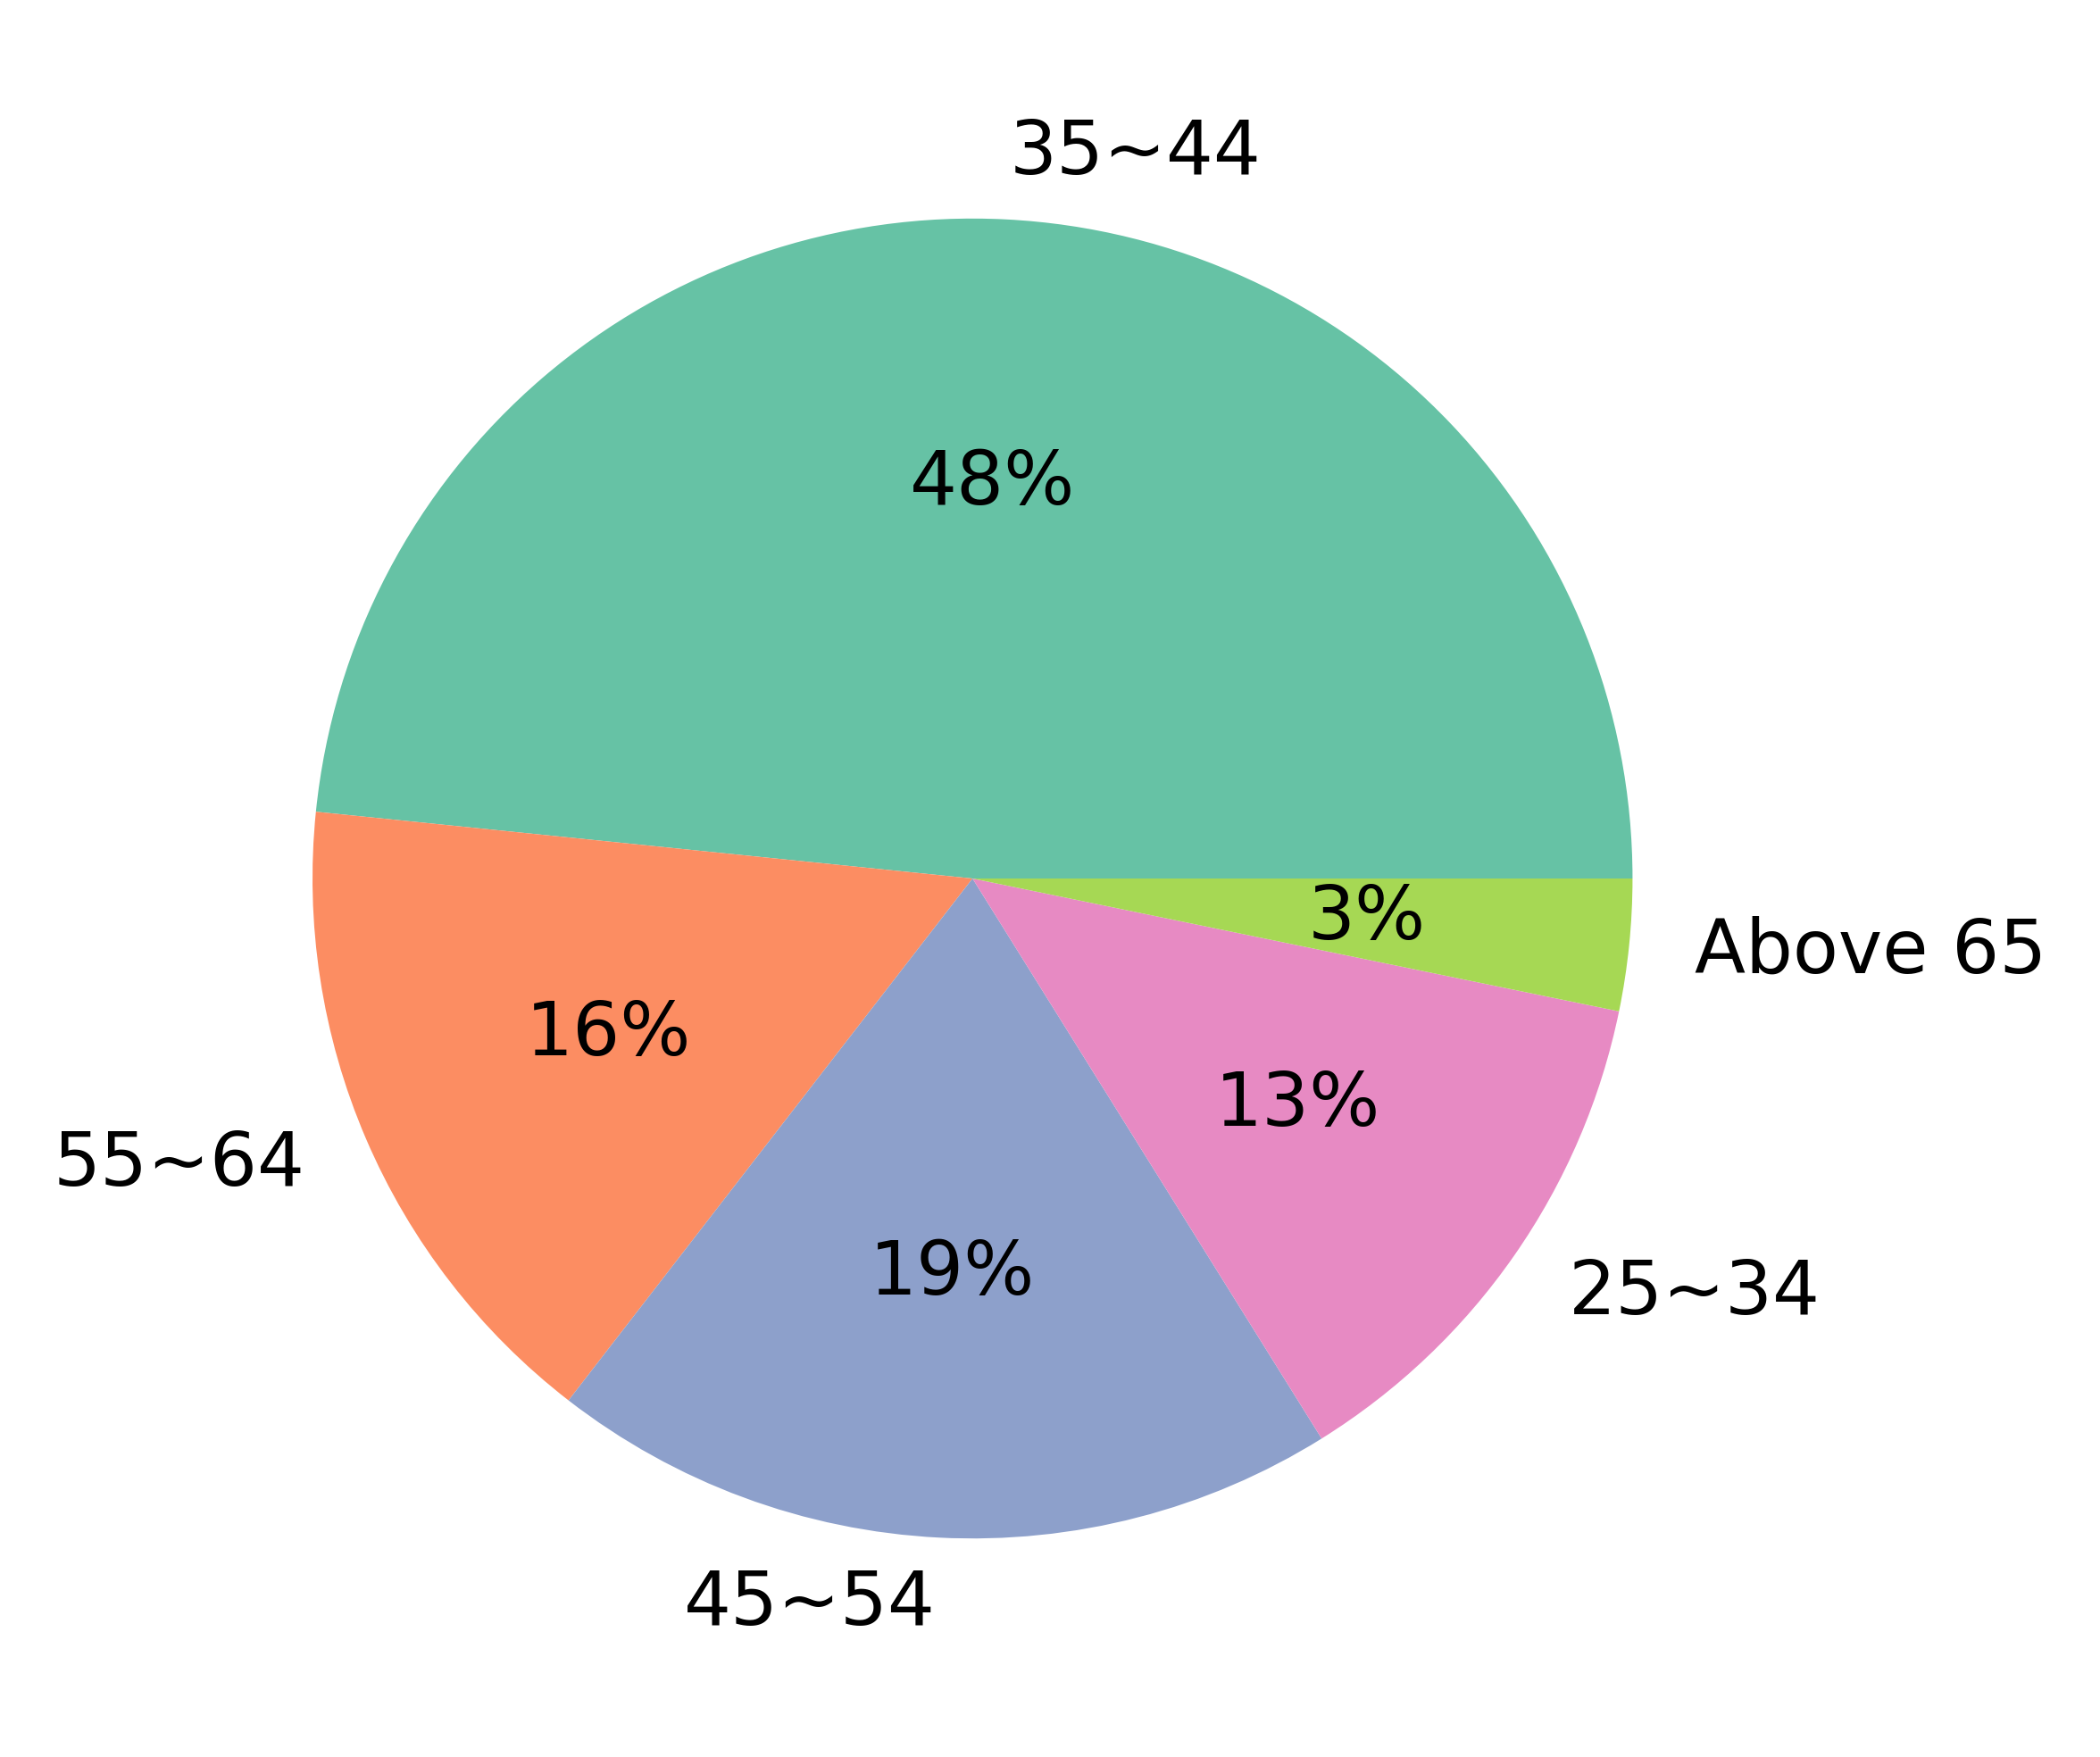

In [11]:
worker_age_dict_counts = Counter(worker_age_dict.values())

plt.figure(figsize=(8, 4), dpi = 600) 

# declaring data 
data = list(dict(worker_age_dict_counts).values())
keys = list(dict(worker_age_dict_counts).keys())
  
# define Seaborn color palette to use 
# palette_color = seaborn.color_palette('bright') 
palette_color = sns.color_palette("Set2")

# plotting data on chart 
ax = plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%') 

# ax.set(xlabel='Scores', ylabel='Count')
# displaying chart 
plt.show() 

In [12]:
mturk_raw_data['Answer.worker_location_live'].value_counts()

Answer.worker_location_live
USA                         205
United States               102
Canada                       40
India                        37
United States of America     20
Portugal                     20
Venezuela                    20
US                           18
England                      14
usa                          13
united states                11
Name: count, dtype: int64

In [13]:
tmp_worker_loc_df = mturk_raw_data[['Answer.worker_location_live', 'WorkerId']].drop_duplicates()
tmp_worker_ids = tmp_worker_loc_df.WorkerId.values
tmp_worker_loc = tmp_worker_loc_df['Answer.worker_location_live'].values
worker_loc_dict = dict(zip(tmp_worker_ids, tmp_worker_loc))
len(worker_loc_dict)
# all_worker_ids = mturk_raw_data.WorkerId.nunique()

31

In [14]:
for k in worker_loc_dict:
    if worker_loc_dict[k].lower() in ['united states', 'usa', 'us', 'united states of america']:
        worker_loc_dict[k] = 'US'
worker_loc_dict

{'A1DMXEJGJY02E1': 'US',
 'A3RVHUY67SVXQV': 'US',
 'A41APS6V2Z1FJ': 'US',
 'A15X8ATAWSRXIF': 'US',
 'A2XZLEY2RCF5VM': 'Canada',
 'A5WWHKD82I8UE': 'US',
 'A34YDGVZKRJ0LZ': 'US',
 'A3B7TNVOISSZ2O': 'US',
 'A3PUUVUDORJS8W': 'England',
 'A3W0SCW5UYEB0F': 'US',
 'AAGBW25TZVAX7': 'US',
 'A377LTGWJKY2IW': 'Canada',
 'A2COPP4Y0UYN0B': 'Portugal',
 'A3I9XLIHPPWPN1': 'US',
 'A2R1GDWV4RLIUY': 'US',
 'A2VO8C41JJIQY9': 'India',
 'AZLZA0Q87TJZO': 'US',
 'A9HQ3E0F2AGVO': 'US',
 'A2I4PRZ9IZMKON': 'US',
 'A1OZPLHNIU1519': 'US',
 'A2FP41BSPG0Y4A': 'US',
 'A31PW970Z2PC5P': 'US',
 'AKQAI78JTXXC9': 'US',
 'A3F5YHQWKPC5MX': 'US',
 'A2BK45LZGGWPLX': 'US',
 'A1TTSDPGBHOO9P': 'US',
 'A3NGN0SM7SBYB9': 'US',
 'A2Y7FD1D7PUGBL': 'Venezuela',
 'ACI8PUCF5OPDC': 'India',
 'A16184N1RO5OJV': 'US',
 'AFPMG8TLP1TND': 'US'}

In [15]:
worker_loc_dict_counts = Counter(worker_loc_dict.values())

In [16]:
dict(worker_loc_dict_counts).values()

dict_values([24, 2, 1, 1, 2, 1])

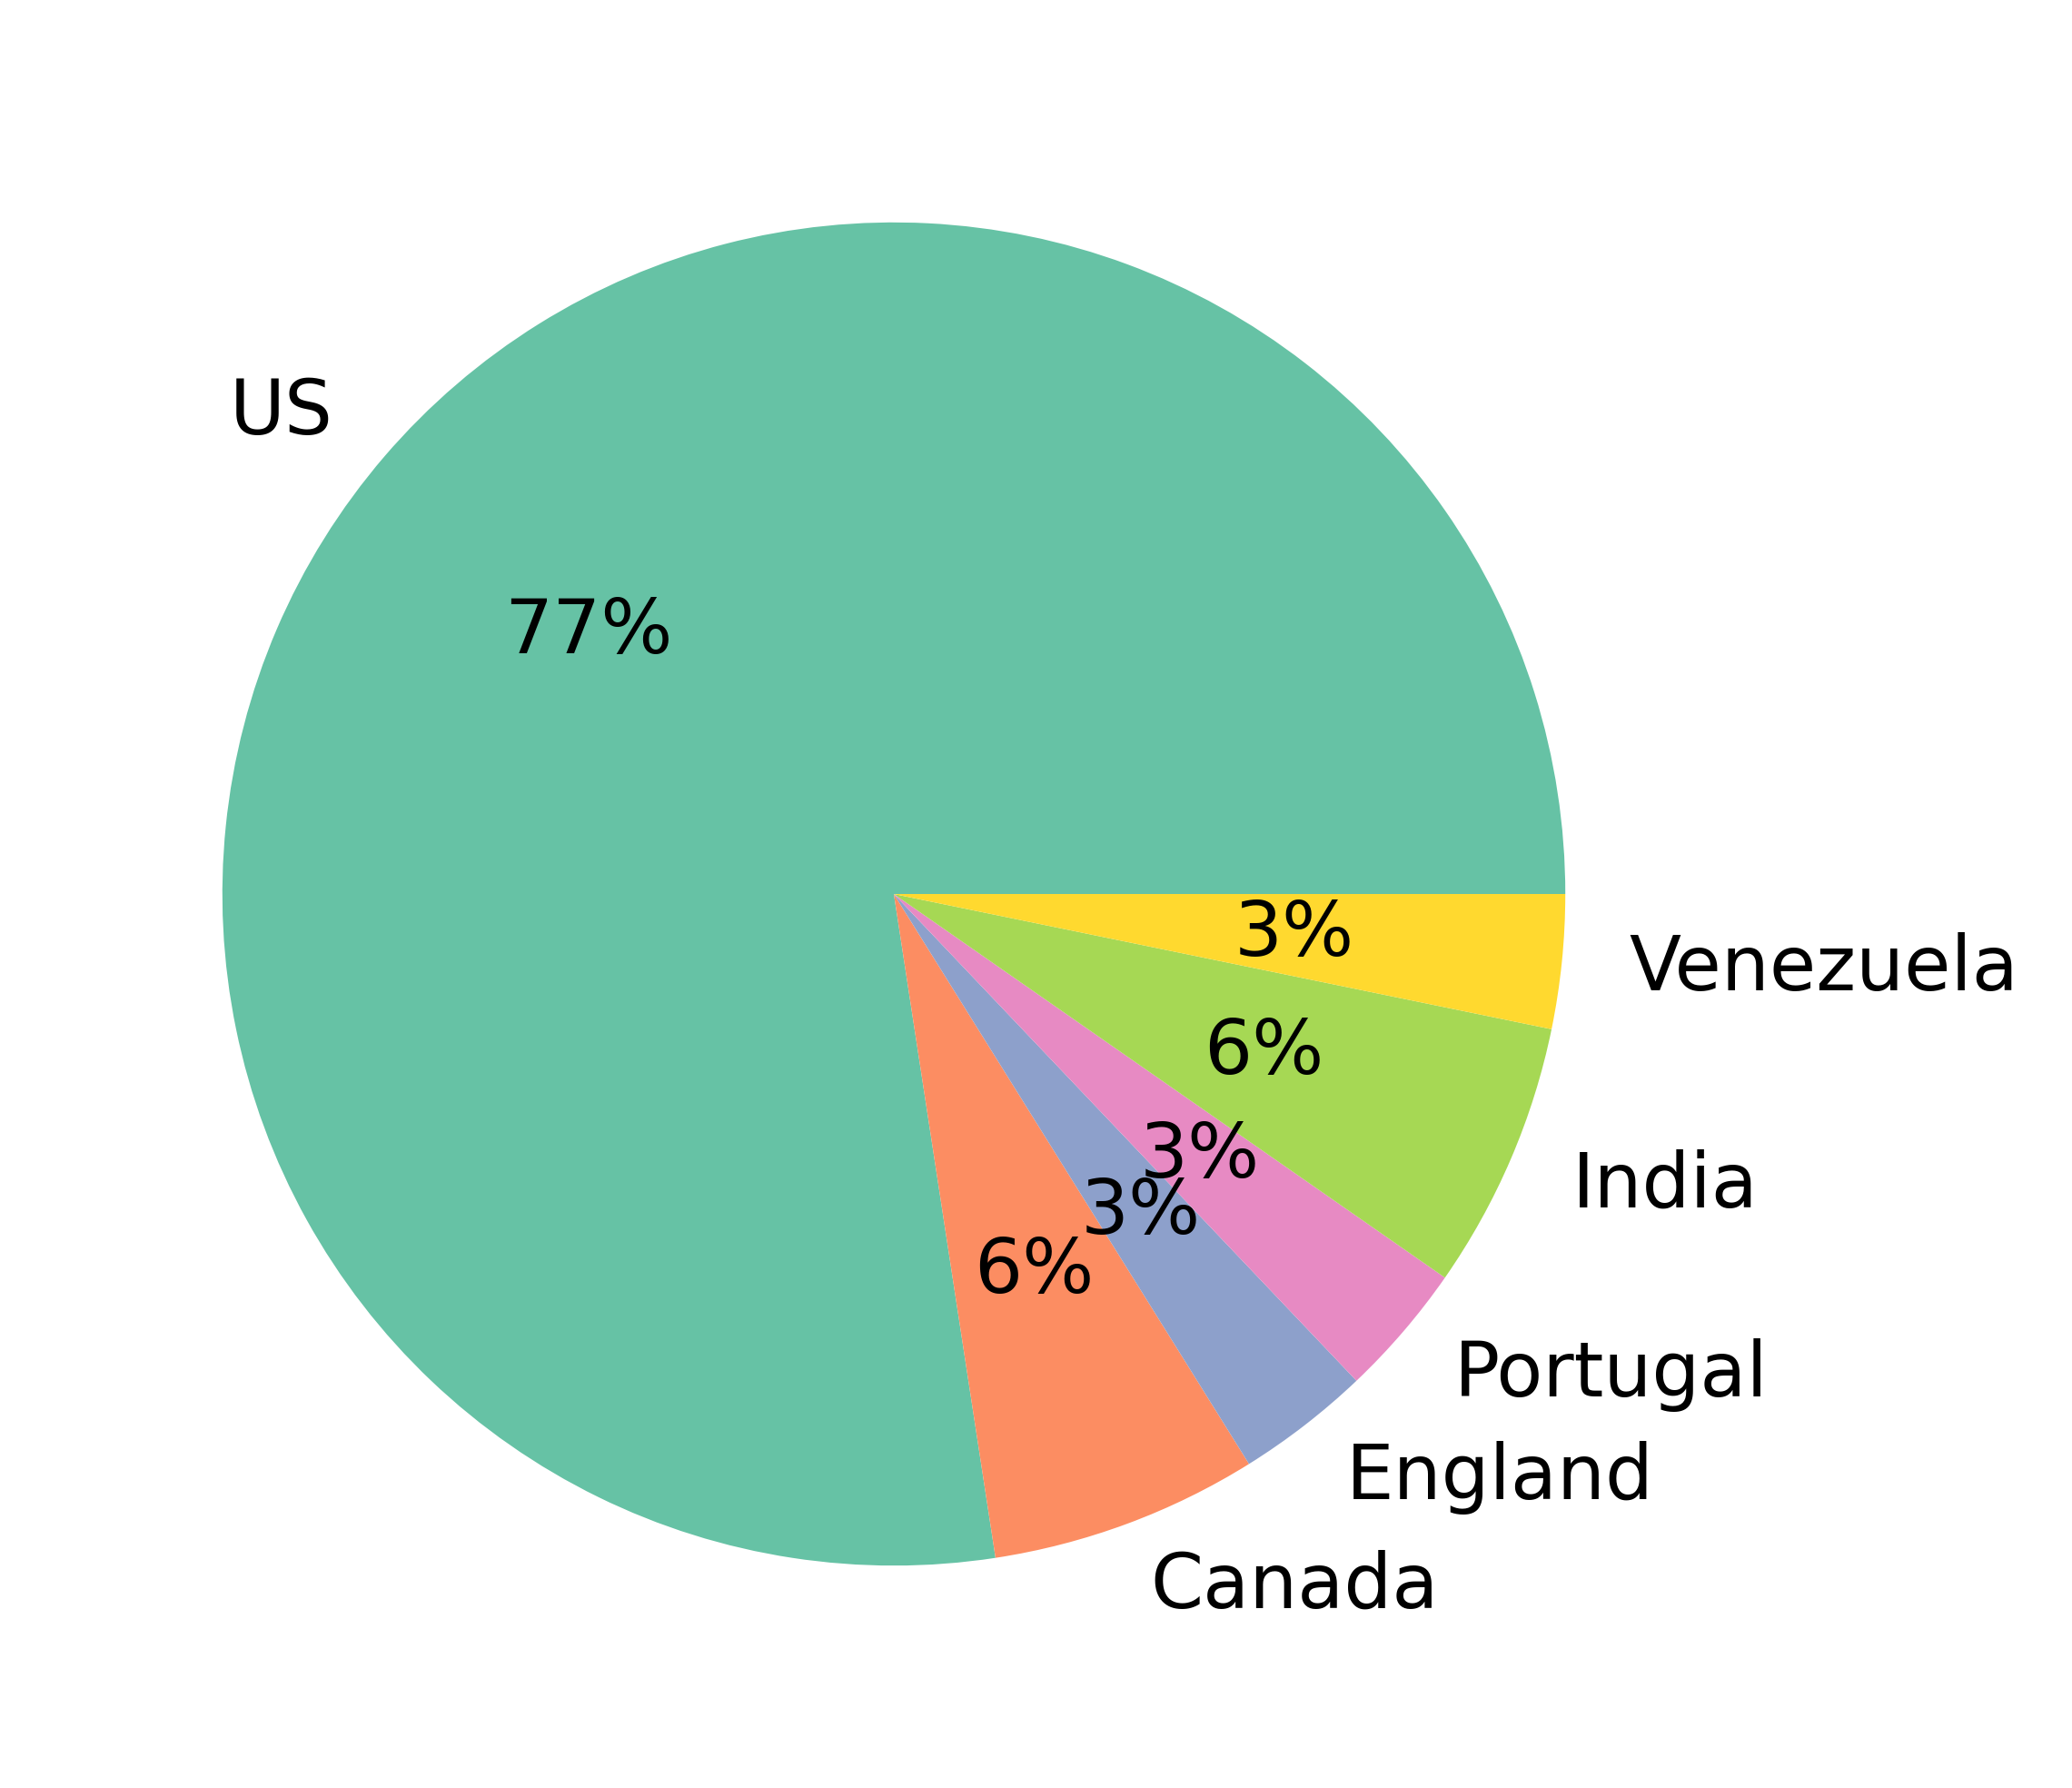

In [17]:
plt.figure(figsize=(8, 4), dpi = 600) 

# declaring data 
data = list(dict(worker_loc_dict_counts).values())
keys = list(dict(worker_loc_dict_counts).keys())
  
# define Seaborn color palette to use 
# palette_color = seaborn.color_palette('bright') 
palette_color = sns.color_palette("Set2")

# plotting data on chart 
ax = plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%') 

# ax.set(xlabel='Scores', ylabel='Count')
# displaying chart 
plt.show() 

In [18]:
# mturk_raw_data.head()

## 3.2 Agreement, Validation

- drop some columns

In [43]:
col_to_drop = [
    'HITTypeId',
    'Title',
    'Description',
    'Keywords',
    'Reward',
    'CreationTime',
    'MaxAssignments',
    'RequesterAnnotation',
    'AssignmentDurationInSeconds',
    'AutoApprovalDelayInSeconds',
    'Expiration',
    'NumberOfSimilarHITs',
    'LifetimeInSeconds',
    # 'AssignmentId',
    'AssignmentStatus',
    'AcceptTime',
    'SubmitTime',
    'AutoApprovalTime',
    'ApprovalTime',
    'RejectionTime',
    'RequesterFeedback',
    'WorkTimeInSeconds',
    'LifetimeApprovalRate',
    'Last30DaysApprovalRate',
    'Last7DaysApprovalRate',
    'Input.example_1',
    'Input.example_2',
    'Input.image_url',
    'Approve',
    'Reject'
]

In [44]:
mturk_raw_data = mturk_raw_data.drop(columns=col_to_drop)
mturk_raw_data.shape

(2500, 76)

- keep first k annotations (if annotation counts are different across ads_id )

In [45]:
# first_k = int(mturk_raw_data[['Input.ads_id', 'HITId']].groupby('Input.ads_id').agg('count')['HITId'].min())
# first_k

In [46]:
# kept_data = []
# for ads_id in mturk_raw_data['Input.ads_id'].unique():
#     tmp_df = copy.deepcopy(mturk_raw_data.loc[mturk_raw_data['Input.ads_id'] == ads_id].iloc[:first_k])
#     kept_data.append(tmp_df)
# mturk_raw_data = pd.concat(kept_data).reset_index(drop = True)
# mturk_raw_data.shape

In [47]:
mturk_raw_data['unique_id'] = range(mturk_raw_data.shape[0])

In [48]:
mturk_raw_data['effectiveness_correct'] = mturk_raw_data.apply(lambda x: x['Answer.effectiveness.' + x['Input.action_correct']], axis = 1)
effectiveness_accuracy = sum(mturk_raw_data['effectiveness_correct']) / mturk_raw_data.shape[0]
effectiveness_accuracy

0.9688

In [49]:
sum(mturk_raw_data['effectiveness_correct']) 

2422

In [50]:
mturk_raw_data['WorkerId'].unique()

array(['A1DMXEJGJY02E1', 'A3RVHUY67SVXQV', 'A41APS6V2Z1FJ',
       'A15X8ATAWSRXIF', 'A2XZLEY2RCF5VM', 'A5WWHKD82I8UE',
       'A34YDGVZKRJ0LZ', 'A3B7TNVOISSZ2O', 'A3PUUVUDORJS8W',
       'A3W0SCW5UYEB0F', 'AAGBW25TZVAX7', 'A377LTGWJKY2IW',
       'A2COPP4Y0UYN0B', 'A3I9XLIHPPWPN1', 'A2R1GDWV4RLIUY',
       'A2VO8C41JJIQY9', 'AZLZA0Q87TJZO', 'A9HQ3E0F2AGVO',
       'A2I4PRZ9IZMKON', 'A1OZPLHNIU1519', 'A2FP41BSPG0Y4A',
       'A31PW970Z2PC5P', 'AKQAI78JTXXC9', 'A3F5YHQWKPC5MX',
       'A2BK45LZGGWPLX', 'A1TTSDPGBHOO9P', 'A3NGN0SM7SBYB9',
       'A2Y7FD1D7PUGBL', 'ACI8PUCF5OPDC', 'A16184N1RO5OJV',
       'AFPMG8TLP1TND', 'A2K8HDNZZQCWU9', 'A21HRQPSI3REF9',
       'A19Z68L0RHQVWL', 'A2RBF3IIJP15IH', 'A2BGAJTWL8F232',
       'A2C9HJC2RDU10C', 'ATR6RB1RULOC0', 'ABO9F0JD9NN54',
       'A15GLJU2DG7DLO', 'A1KTASRQIPL490', 'A374VECA56GM56',
       'A1KWITRMPO7BUQ'], dtype=object)

In [27]:
# mturk_raw_data[['WorkerId', 'effectiveness_correct']].groupby('WorkerId').agg('count')

In [28]:
# mturk_raw_data[['WorkerId', 'effectiveness_correct']].query('WorkerId == "A1KTASRQIPL490"')

**post processing steps**
1) merge counts (value translation + accumulation)
2) normalize counts

In [112]:
# mturk_raw_data['WorkerId']

In [62]:
tmp_columns = ['pc', 'atypicality', 'artistic']
answer_choices = {
    'disagree': -1, 
    'neutral': 0, 
    'agree': 1
}

def helper_normalize_lst(lst, bin = 7): # normalize to bin = 7 (i.e. same as -3~3)
    if max(lst) == min(lst): return [0] * len(lst)
    
    mean = np.mean(lst)
    std = np.std(lst)
    lst_norm = [(i - mean) / std for i in lst]
    lst_norm_max = max(lst_norm)
    lst_norm_min = min(lst_norm)
    lst_norm = [
        int((i - lst_norm_min) / (lst_norm_max - lst_norm_min) * bin - bin / 2)
        for i in lst_norm
    ]
    return lst_norm
    
def find_acc_value(tmp_all_values, method, normalize_bin = 0):
    if method == 'single_pos':
        acc_values = [] 
        for i in range(len(tmp_all_values[0].values)):
            item_value = 0
            for lst in tmp_all_values:
                lst = lst.values
                if lst[i] == 1:
                    item_value = 1
            acc_values.append(item_value)
        return acc_values
    
    tmp_sum_lst = []
    for i in range(len(tmp_all_values[0].values)):
        item_value = 0
        tmp_sum = sum([lst.values[i] for lst in tmp_all_values])
        tmp_sum_lst.append(tmp_sum)
    
    if normalize_bin:
        tmp_sum_lst = helper_normalize_lst(tmp_sum_lst, normalize_bin)

    acc_values = []
    for tmp_sum in tmp_sum_lst:
        if method == 'threshold_0' and tmp_sum > 0: item_value = 1
        if method == 'threshold_3' and tmp_sum == 3: item_value = 1
        if method == 'raw': item_value = tmp_sum
        acc_values.append(item_value)
    return acc_values

normalize_bin = 3
processed_data = []
for worker_id in mturk_raw_data.WorkerId.unique():
    tmp_df = copy.deepcopy(mturk_raw_data.query('WorkerId == "{}"'.format(worker_id)))
    for col in tmp_columns:
        # 1. value translation
        tmp_all_values = []
        for sub_question in ['_1', '_2', '_3']:
            tmp_answer_values = []
            for ans in answer_choices:
                tmp_col = 'Answer.' + col + sub_question + '.' + ans
                tmp_values = tmp_df[tmp_col].apply(lambda x: answer_choices[ans] if x else 0)
                tmp_answer_values.append(tmp_values)
            tmp_df['value_' + col + sub_question] = sum(tmp_answer_values)
            tmp_all_values.append(sum(tmp_answer_values))
        
        # 2. value accumulation
        tmp_df['acc_raw_' + col] = find_acc_value(tmp_all_values, method = 'raw')
        tmp_df['acc_th0_' + col] = find_acc_value(tmp_all_values, method = 'threshold_0')
        tmp_df['acc_th3_' + col] = find_acc_value(tmp_all_values, method = 'threshold_3')
        tmp_df['acc_single_' + col] = find_acc_value(tmp_all_values, method = 'single_pos')

        # 3. normalization 

        tmp_df['acc_norm_raw_' + col] = find_acc_value(tmp_all_values, method = 'raw', normalize_bin = normalize_bin)
        tmp_df['acc_norm_th0_' + col] = find_acc_value(tmp_all_values, method = 'threshold_0', normalize_bin = normalize_bin)
        tmp_df['acc_norm_th3_' + col] = find_acc_value(tmp_all_values, method = 'threshold_3', normalize_bin = normalize_bin)
    processed_data.append(tmp_df)

# mturk_raw_data.tail(2)
mturk_processed_df = pd.concat(processed_data).sort_values(by = 'unique_id')

effectiveness_map = {
    'a': 'a',
    'b': 'b',
    'c': 'c',
    'd': 'd',
    'e': 'e'
}
age_map = {
    'age_18': 18, 
    'age_18_24': 24, 
    'age_25_34': 30, 
    'age_35_44': 40, 
    'age_45_54': 50, 
    'age_55_64': 60, 
    'age_65': 70, 
    'unknown': -1, 
}
overall_map = {str(i): i for i in range(1, 6)}

def find_multi_choice(s, feature_map, feature):
    for e in feature_map:
        if s['Answer.{}.{}'.format(feature, e)]:
            return feature_map[e]
    return ''
mturk_processed_df['value_effectiveness'] = mturk_processed_df.apply(lambda x: find_multi_choice(x, effectiveness_map, 'effectiveness'), axis = 1)
mturk_processed_df['value_overall'] = mturk_processed_df.apply(lambda x: find_multi_choice(x, overall_map, 'overall'), axis = 1)

# 3. demo data
col_location = 'Answer.worker_location_live'
mturk_processed_df['demo_location'] = mturk_processed_df[col_location]
mturk_processed_df['demo_age'] = mturk_processed_df.apply(lambda x: find_multi_choice(x, age_map, 'age'), axis = 1)

mturk_processed_df.shape

(950, 115)

In [63]:
all_overall_data = []
mturk_processed_df_overall = mturk_processed_df[['unique_id', 'WorkerId', 'value_overall']]
for worker_id in mturk_processed_df_overall.WorkerId.unique():
    tmp_df = copy.deepcopy(mturk_processed_df_overall.query('WorkerId == "{}"'.format(worker_id)))
    tmp_df['value_overall'] = helper_normalize_lst(tmp_df['value_overall'].values, bin = normalize_bin)
    all_overall_data.append(tmp_df)
all_overall_df = pd.concat(all_overall_data).sort_values(by = 'unique_id')
all_overall_df.head(10)

,unique_id,WorkerId,value_overall
0,0,A1DMXEJGJY02E1,0
1,1,A3RVHUY67SVXQV,0
2,2,A41APS6V2Z1FJ,0
3,3,A15X8ATAWSRXIF,0
4,4,A2XZLEY2RCF5VM,0
5,5,A5WWHKD82I8UE,0
6,6,A34YDGVZKRJ0LZ,1
7,7,A3B7TNVOISSZ2O,0
8,8,A3PUUVUDORJS8W,0
9,9,A3W0SCW5UYEB0F,0


In [64]:
mturk_processed_df['value_overall_norm'] = all_overall_df['value_overall']

In [65]:
# mturk_processed_df.to_csv(mturk_data_dir + 'subset_0.5/mturk_processed_df.csv', index = False)

In [66]:
# mturk_raw_data.groupby('demo_location').agg('count')['Input.ads_id'] 
# mturk_processed_df[['WorkerId', 'Input.ads_id']].groupby('WorkerId').agg('count').rename(columns = {'Input.ads_id': 'count'}).to_csv(mturk_data_dir + 'subset_0.5/worker_hits_count.csv')

In [67]:
mturk_processed_df['value_overall_norm'].unique()

array([ 0,  1, -1])

In [68]:
mturk_processed_df['value_overall_norm'].value_counts()

value_overall_norm
 0    627
 1    176
-1    147
Name: count, dtype: int64

In [69]:
# # first std, then min-max
# def normalize_lst(lst, bin = 7): # normalize to bin = 7 (i.e. same as -3~3)
#     if max(lst) == min(lst): return [0] * len(lst)
    
#     mean = np.mean(lst)
#     std = np.std(lst)
#     lst_norm = [(i - mean) / std for i in lst]
#     lst_norm_max = max(lst_norm)
#     lst_norm_min = min(lst_norm)
#     lst_norm = [
#         int((i - lst_norm_min) / (lst_norm_max - lst_norm_min) * bin - bin / 2)
#         for i in lst_norm
#     ]
#     return lst_norm


# acc_cols = [col for col in mturk_raw_data.columns if 'acc_' in col]
# normalized_data = []
# for worker_id in mturk_raw_data.WorkerId.unique():
#     tmp_df = copy.deepcopy(mturk_raw_data[['unique_id', 'WorkerId'] + acc_cols].query('WorkerId == "{}"'.format(worker_id)))
#     if tmp_df.shape[0] == 1: normalized_data.append(tmp_df.drop(columns=['WorkerId']))
#     for col in acc_cols:
#         tmp_df[col] = normalize_lst(tmp_df[col])
#     normalized_data.append(tmp_df)
# pd.concat(normalized_data)

In [70]:
def mturk_get_kappa_data(mturk_raw_data, column, data_maping = None):
    # unique_values = accumulate_data[column + '_agree'].unique()
    def count_kappa(data, data_maping):
        if data_maping is None:
            unique_values = data.unique()
        else:
            unique_values = list(data_maping.values())
        result = {k: 0 for k in unique_values}
        for v in data.values:
            # v = int(v)
            if data_maping is None:
                if v in result: result[v] += 1
            else:
                if data_maping[v] in result: result[data_maping[v]] += 1
        return result
    kappa_data = mturk_raw_data[[column, 'Input.ads_id']].groupby('Input.ads_id').agg(lambda data: count_kappa(data, data_maping = data_maping))[column].values
    kappa_data = pd.DataFrame(list(kappa_data)).fillna(0)
    return kappa_data

In [71]:
# tmp_kappa_data = mturk_get_kappa_data(mturk_raw_data, 'acc_single_atypicality')
# statsmodels.stats.inter_rater.fleiss_kappa(tmp_kappa_data, 'fleiss')

In [72]:
# mturk_raw_data.columns

In [73]:
# np.unique(mturk_raw_data.value_overall.values, return_counts = True)

In [74]:
# data validation 
effectiveness_correct = mturk_processed_df.apply(lambda x: x['Answer.effectiveness.' + x['Input.action_correct']], axis = 1)
# raw_mturk_data['effectiveness_valid'] = effectiveness_correct
effectiveness_acc = sum(effectiveness_correct.values) / mturk_processed_df.shape[0]
effectiveness_acc

np.float64(0.9610526315789474)

In [75]:
fleiss_value_lst = []
for col in sorted(list(mturk_processed_df.columns)):
    if 'acc_' in col:
        data_maping = None
    elif 'value_' in col:
        if 'effectiveness' in col or 'overall' in col:
            data_maping = None
        else:
            # data_maping = {
            #     0: 0,
            #     -1: 0,
            #     1: 1
            # }
            data_maping = None
    else:
        continue 
    tmp_kappa_data = mturk_get_kappa_data(mturk_processed_df, col, data_maping)
    # display(tmp_kappa_data)
    # fleiss_value = round(statsmodels.stats.inter_rater.fleiss_kappa(tmp_kappa_data, 'randolph'), 4)
    fleiss_value = round(statsmodels.stats.inter_rater.fleiss_kappa(tmp_kappa_data), 4)
    print(col, fleiss_value)
    fleiss_value_lst.append({
        'col': col,
        'fleiss': fleiss_value,
        'norm': 'norm' in col,
        'acc': 'acc_' in col
    })
fleiss_value_df = pd.DataFrame(fleiss_value_lst)

acc_norm_raw_artistic 0.1557
acc_norm_raw_atypicality 0.3289
acc_norm_raw_pc 0.2953
acc_norm_th0_artistic 0.0555
acc_norm_th0_atypicality 0.1871
acc_norm_th0_pc 0.0344
acc_norm_th3_artistic nan
acc_norm_th3_atypicality nan
acc_norm_th3_pc nan
acc_raw_artistic 0.074
acc_raw_atypicality 0.2775
acc_raw_pc 0.1901
acc_single_artistic 0.2798
acc_single_atypicality 0.4161
acc_single_pc 0.4478
acc_th0_artistic 0.0237
acc_th0_atypicality 0.1448
acc_th0_pc 0.0487
acc_th3_artistic 0.1942
acc_th3_atypicality 0.1319
acc_th3_pc 0.0468
value_artistic_1 0.1869
value_artistic_2 0.1063
value_artistic_3 0.1287
value_atypicality_1 0.3267
value_atypicality_2 0.3416
value_atypicality_3 0.3339
value_effectiveness 0.9351
value_overall 0.1089
value_overall_norm 0.1362
value_pc_1 0.3566
value_pc_2 0.2279
value_pc_3 0.2897


/Users/joeyhou/Developer/research/ads/.conda/lib/python3.10/site-packages/statsmodels/stats/inter_rater.py:266: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)
/Users/joeyhou/Developer/research/ads/.conda/lib/python3.10/site-packages/statsmodels/stats/inter_rater.py:266: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)
/Users/joeyhou/Developer/research/ads/.conda/lib/python3.10/site-packages/statsmodels/stats/inter_rater.py:266: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


In [76]:
fleiss_value_df.query('norm == True').sort_values(by = 'col')

,col,fleiss,norm,acc
0,acc_norm_raw_artistic,0.1557,True,True
1,acc_norm_raw_atypicality,0.3289,True,True
2,acc_norm_raw_pc,0.2953,True,True
3,acc_norm_th0_artistic,0.0555,True,True
4,acc_norm_th0_atypicality,0.1871,True,True
5,acc_norm_th0_pc,0.0344,True,True
6,acc_norm_th3_artistic,NaN,True,True
7,acc_norm_th3_atypicality,NaN,True,True
8,acc_norm_th3_pc,NaN,True,True
29,value_overall_norm,0.1362,True,False


In [77]:
fleiss_value_df.query('(norm == False) & (acc == True)').sort_values(by = 'col')

,col,fleiss,norm,acc
9,acc_raw_artistic,0.0740,False,True
10,acc_raw_atypicality,0.2775,False,True
11,acc_raw_pc,0.1901,False,True
12,acc_single_artistic,0.2798,False,True
13,acc_single_atypicality,0.4161,False,True
14,acc_single_pc,0.4478,False,True
15,acc_th0_artistic,0.0237,False,True
16,acc_th0_atypicality,0.1448,False,True
17,acc_th0_pc,0.0487,False,True
18,acc_th3_artistic,0.1942,False,True


In [46]:
# np.unique(mturk_raw_data['value_overall'].values, return_counts = True)

In [78]:
from scipy import stats

In [79]:
input_cols = [
    'demo_age',
] + sorted([col for col in mturk_processed_df.columns if 'acc_' in col and 'norm' in col])

target_cols = ['value_overall_norm']

for input_col in input_cols:
    for target_col in target_cols:
        try:
            res = stats.pearsonr(mturk_processed_df[input_col].values, mturk_processed_df[target_col].values)
            # print('{} -> {}: {} (p: {})'.format(input_col, target_col, round(res.rvalue**2, 4), round(res.pvalue**2, 4)))
            print('{} -> {}: {} (p: {})'.format(input_col, target_col, round(res.statistic, 4), round(res.pvalue, 4)))
        except:
            print('{} -> {}: None [cannot perform linear test (all values identical)]'.format(input_col, target_col))

demo_age -> value_overall_norm: -0.0133 (p: 0.6829)
acc_norm_raw_artistic -> value_overall_norm: 0.5462 (p: 0.0)
acc_norm_raw_atypicality -> value_overall_norm: 0.4361 (p: 0.0)
acc_norm_raw_pc -> value_overall_norm: 0.5265 (p: 0.0)
acc_norm_th0_artistic -> value_overall_norm: 0.0412 (p: 0.2045)
acc_norm_th0_atypicality -> value_overall_norm: 0.0212 (p: 0.5146)
acc_norm_th0_pc -> value_overall_norm: 0.0009 (p: 0.977)
acc_norm_th3_artistic -> value_overall_norm: nan (p: nan)
acc_norm_th3_atypicality -> value_overall_norm: nan (p: nan)
acc_norm_th3_pc -> value_overall_norm: nan (p: nan)


/var/folders/d5/5prsm7lx46zd_rbpq02ct2m80000gn/T/ipykernel_30083/717746464.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = stats.pearsonr(mturk_processed_df[input_col].values, mturk_processed_df[target_col].values)


In [250]:
# mturk_raw_data[['Input.ads_id', 'acc_th3_atypicality', 'acc_raw_atypicality', 'acc_th3_pc', 'acc_raw_pc', 'value_overall', 'demo_age']].to_csv(mturk_data_dir + 'subset_0.5/sample_acc_th3_pc.csv', index = False)

In [13]:
# import math 
# 2.929 * (math.pi)**(1/2) * 2 / math.e, 12 / math.pi

In [10]:
# update qualification 
worker_df = pd.read_csv(mturk_data_dir + 'workers/workers_0514_v2.csv')
# worker_df["UPDATE-Rosie's White List"] = worker_df.apply(lambda x: 2 if x['Worker ID'] in mturk_raw_data.WorkerId.values else x["UPDATE-Rosie's White List"], axis = 1)
# worker_df = worker_df[["UPDATE-Rosie's White List", 'Worker ID']]
sum(worker_df["CURRENT-Rosie's White List"] == 2)

6

In [14]:
sum(worker_df["CURRENT-Rosie's White List"] == 1)

5

In [503]:
worker_df[["CURRENT-Rosie's White List"]].sum()

CURRENT-Rosie's White List    11.0
dtype: float64

In [494]:
# worker_df.to_csv(mturk_data_dir + 'workers/workers_0514_v1_updated.csv', index = False)

In [497]:
worker_df.loc[worker_df['Worker ID'] == 'A16184N1RO5OJV']

,Worker ID,Link to Individual Worker Page,Number of HITs approved or rejected - Lifetime,Number of HITs approved - Lifetime,Your Lifetime approval rate,Number of HITs approved or rejected - Last 30 days,Number of HITs approved - Last 30 days,Your Last 30 days approval rate,Number of HITs approved or rejected - Last 7 days,Number of HITs approved - Last 7 days,...,UPDATE-self,CURRENT-Rosie's White List,UPDATE-Rosie's White List,CURRENT-Ads Creativity - v2,UPDATE-Ads Creativity - v2,CURRENT-Ads Creativity - Good,UPDATE-Ads Creativity - Good,CURRENT BlockStatus,UPDATE BlockStatus,BlockReason
10,A16184N1RO5OJV,https://requester.mturk.com/workers/A16184N1RO...,0,0,0.00%,0,0,0.00%,0,0,...,NaN,1.0,2.0,NaN,NaN,NaN,NaN,Never Blocked,NaN,NaN


In [498]:
mturk_raw_data.WorkerId.unique()

array(['A1TTSDPGBHOO9P', 'A3NGN0SM7SBYB9', 'A2Y7FD1D7PUGBL',
       'ACI8PUCF5OPDC', 'A16184N1RO5OJV', 'A1DMXEJGJY02E1',
       'A3W0SCW5UYEB0F', 'AFPMG8TLP1TND', 'A41APS6V2Z1FJ',
       'A3RVHUY67SVXQV', 'A2I4PRZ9IZMKON'], dtype=object)

## 3.2 Worker Job Counts (for Bonus)

In [29]:
existing_bonus = pd.read_csv(mturk_data_dir + 'subset_1.1/worker_job_counts_1113.csv')
existing_bonus_dict = dict(zip(existing_bonus.WorkerId.values, existing_bonus.bonus.values))
# existing_bonus_dict = {
#     'A1KWITRMPO7BUQ': 0.5,
#     'A3NGN0SM7SBYB9': 0.5,
#     'A1TTSDPGBHOO9P': 0.5,
#     'A19Z68L0RHQVWL': 0.5,
#     'AKQAI78JTXXC9': 0.5
# }

bonus_per_hit = 0.1
data_version = '1.1'

In [30]:
assignment_dict = dict(zip(mturk_raw_data['WorkerId'].values, mturk_raw_data['AssignmentId'].values))
worker_job_counts = mturk_raw_data[['WorkerId', 'Input.ads_id', 'AssignmentId']].groupby('WorkerId').agg('count')
worker_job_counts['WorkerId'] = worker_job_counts.index
worker_job_counts['bonus'] = worker_job_counts['Input.ads_id'].apply(lambda x: x * bonus_per_hit)

def find_bonus(x):
    if x['WorkerId'] in existing_bonus_dict:
        return x['Input.ads_id'] * bonus_per_hit - existing_bonus_dict[x['WorkerId']]
    else:
        return x['Input.ads_id'] * bonus_per_hit
worker_job_counts['extra_bonus'] = worker_job_counts.apply(find_bonus, axis = 1)
worker_job_counts['AssignmentId'] = [assignment_dict[worker_id] for worker_id in worker_job_counts.index]

In [31]:
worker_job_counts.to_csv(mturk_data_dir + 'subset_{}/worker_job_counts_1118.csv'.format(data_version))
worker_job_counts

,Input.ads_id,AssignmentId,WorkerId,bonus,extra_bonus
WorkerId,,,,,
A15X8ATAWSRXIF,30,3AQF3RZ55SY38584TPYFEOVNWMH6FV,A15X8ATAWSRXIF,3.0,0.000000e+00
A16184N1RO5OJV,30,36ZN444YTBED72GYUTQUYLT5TROOIX,A16184N1RO5OJV,3.0,0.000000e+00
A19Z68L0RHQVWL,22,34QN5IT0TJ7ZFFC2JMCSVV4ACIN806,A19Z68L0RHQVWL,2.2,7.000000e-01
A1DMXEJGJY02E1,30,30BUDKLTXXBFJN8UTV4440VMKQY5EW,A1DMXEJGJY02E1,3.0,0.000000e+00
A1KTASRQIPL490,28,32M8BPYGAD2PFPZ06ADMTCL4MNDIG7,A1KTASRQIPL490,2.8,2.800000e+00
A1KWITRMPO7BUQ,5,3V26SBZTBXUB1WJFW6PXEE40CN5ZZJ,A1KWITRMPO7BUQ,0.5,0.000000e+00
A1OZPLHNIU1519,30,3EQHHY4HQC8D314LZQUS43HZ4V05GO,A1OZPLHNIU1519,3.0,0.000000e+00
A1TTSDPGBHOO9P,1,3CTOC39K3R62H785VPUSZ0MAGC97JY,A1TTSDPGBHOO9P,0.1,0.000000e+00
A21HRQPSI3REF9,8,323Q6SJS82WJ5USLP8PJBFKDMRFHFO,A21HRQPSI3REF9,0.8,8.000000e-01


In [32]:
worker_job_counts.shape

(31, 5)

In [74]:
18 / (60 / 2.5)

0.75

In [136]:
(0.5 / 1.25) * 60

24.0

In [186]:
(0.5 / 1.5) * 60

20.0

In [187]:
(0.5 / 2) * 60

15.0

# Archived 

## 3.2 Hourly Rate

In [44]:
# batch_result_df = pd.read_csv('../mturk/mturk_raw_results.0.3.csv')
# batch_result_df.head(2)

In [179]:
# # work time for good worker
# good_worker_time = batch_result_df.loc[batch_result_df.WorkerId.apply(lambda x: x in good_turker_id)].WorkTimeInSeconds#.apply(lambda x: x / 60)
# sns.displot(good_worker_time)

In [180]:
id_2_count_dict = dict(batch_result_df.groupby('WorkerId').agg('count')['CreationTime']) #.sort_values(ascending=False).values[:20]

In [181]:
batch_result_df['count'] = batch_result_df.WorkerId.apply(lambda x: id_2_count_dict[x])
batch_result_df.query('count > 1').sort_values(by = ['count', 'WorkerId'], ascending= False)[['WorkerId', 'AcceptTime', 'SubmitTime', 'WorkTimeInSeconds']]

,WorkerId,AcceptTime,SubmitTime,WorkTimeInSeconds
2,A2Z2ERN56ZH745,Mon May 06 20:37:23 PDT 2024,Mon May 06 20:44:01 PDT 2024,398
49,A2Z2ERN56ZH745,Mon May 06 21:37:37 PDT 2024,Mon May 06 21:47:45 PDT 2024,608
79,A2Z2ERN56ZH745,Mon May 06 20:37:33 PDT 2024,Mon May 06 21:19:51 PDT 2024,2538
39,APT8G4J3TGDWK,Mon May 06 20:58:11 PDT 2024,Mon May 06 21:22:11 PDT 2024,1440
59,APT8G4J3TGDWK,Mon May 06 20:37:33 PDT 2024,Mon May 06 21:20:38 PDT 2024,2585
43,AB76VPCQT7N7L,Mon May 06 20:37:33 PDT 2024,Mon May 06 21:14:44 PDT 2024,2231
54,AB76VPCQT7N7L,Mon May 06 21:16:27 PDT 2024,Mon May 06 21:45:44 PDT 2024,1757
38,A2XHF4RYEIYWR0,Mon May 06 20:37:23 PDT 2024,Mon May 06 21:16:09 PDT 2024,2326
89,A2XHF4RYEIYWR0,Mon May 06 20:25:24 PDT 2024,Mon May 06 21:15:29 PDT 2024,3005
15,A2X85AAWK4C003,Mon May 06 19:37:08 PDT 2024,Mon May 06 19:39:56 PDT 2024,168


In [183]:
# good_worker_df = copy.deepcopy(batch_result_df.loc[batch_result_df.WorkerId.apply(lambda x: x in good_turker_id)])
# good_worker_df.shape

In [184]:
# good_worker_df[['WorkerId', 'AcceptTime', 'SubmitTime', 'WorkTimeInSeconds']].sort_values(by = 'WorkerId')


In [185]:
batch_result_df['hr_rate'] = batch_result_df['WorkTimeInSeconds'].apply(lambda x: 0.15 / (x / 3600))
batch_result_df.hr_rate.sort_values()

36    0.154683
64    0.156160
74    0.156658
9     0.158870
92    0.160190
        ...   
67    4.251969
95    4.655172
25    6.136364
24    7.826087
82    7.941176
Name: hr_rate, Length: 100, dtype: float64

In [186]:
# good_worker_time.mean()

In [187]:
# sns.displot(batch_result_df.hr_rate)

In [188]:
batch_result_df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.image_url',
       'Input.topic', 'Input.action_a', 'Input.action_b', 'Input.action_c',
       'Input.action_d', 'Input.action_e', 'Input.ads_id', 'Input.atypical',
       'Input.example_1', 'Input.example_2', 'Input.action_correct',
       'Answer.artistic_1.agree', 'Answer.artistic_1.disagree',
       'Answer.artistic_1.neutral', 'Answer.artistic_2.agree',
       'Answer.artistic_2.disagree', 'Answer.artistic_2.neutral',
       'Answer.artis

In [189]:
# batch_result_df[['AcceptTime', 'SubmitTime', 'WorkTimeInSeconds']]

## 3.3 Agreement - Old Data

In [3]:
mturk_data = pd.read_csv('../mturk/mturk.0.2.csv')
mturk_data.shape

(100, 58)

In [126]:
####### clean data #######
mturk_results = []
for i in range(mturk_data.shape[0]):
    row = mturk_data.iloc[i]
    atypical = row['Answer.atypicality.yes']
    atypical_reason = row['Answer.atypicality_reason']

    pc = row['Answer.peer_comparison.yes']
    pc_reason = row['Answer.peer_comparison_reason']

    effectiveness = ''
    for choice in ['a', 'b', 'c', 'd', 'e']:
        if row['Answer.effectiveness.{}'.format(choice)]:
            effectiveness = choice
            break

    overall = ''
    for choice in [1, 2, 3, 4, 5]:
        if bool(row['Answer.overall.{}'.format(choice)]):
            overall = choice
            break
        if overall == '':
            overall = 3 # HARD FIX!
    mturk_results.append({
        'atypical': atypical,
        'atypical_reason': atypical_reason,
        'pc': pc,
        'pc_reason': pc_reason,
        'effectiveness': effectiveness,
        'effectiveness_true': row['Input.action_correct'],
        'overall': overall,
        'HITId': row['HITId'],
        'ads_id': row['Input.image_url'].replace('https://people.cs.pitt.edu/~mzhang/image_ads/', '')
    })
mturk_results = pd.DataFrame(mturk_results)
mturk_results.overall.unique()

array([3, 2, 5, 4, 1])

In [127]:
mturk_results = mturk_results.query('overall != ""')

In [128]:
sum(mturk_results.overall == ''), mturk_results.shape

(0, (100, 9))

In [129]:
# !pip install statsmodels

In [130]:
import statsmodels.stats.inter_rater

In [220]:
unique_values_dict = {
    'atypical': [True, False],
    'overall': [1, 2, 3, 4, 5],
    'pc': [True, False],
    'effectiveness': ['a', 'b', 'c', 'd', 'e', 'uk']
}
def mturk_get_kappa_data(mturk_results, column):
    # N = mturk_results['ads_id'].nunique()
    # n = int(mturk_results.shape[0] / N)
    # k = mturk_results[column].unique()
    unique_values = unique_values_dict[column] # list(mturk_results[column].unique())
    def count_kappa(data, keys):
        result = {k: 0 for k in keys}
        for v in data.values:
            if v in result:
                result[v] += 1
        return result
    kappa_data = mturk_results[[column, 'ads_id']].groupby('ads_id').agg(lambda data: count_kappa(data, keys = unique_values))[column].values
    kappa_data = pd.DataFrame(list(kappa_data))
    return kappa_data

### 3.3.1 effectiveness

In [132]:
mturk_results.effectiveness = mturk_results.effectiveness.apply(lambda x: x if x != '' else 'uk')

In [133]:
# kappa_data_atypical

In [134]:
# kappa_data_atypical.sum()

In [135]:
kappa_data_atypical = mturk_get_kappa_data(mturk_results, 'atypical')
fleiss_kappa_atypical = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_atypical, 'fleiss'), 4)
randolph_kappa_atypical = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_atypical, 'randolph'), 4)

print(fleiss_kappa_atypical, randolph_kappa_atypical)

-0.12 0.16


In [142]:
kappa_data_atypical

,True,False
0,4,1
1,3,2
2,5,0
3,3,2
4,4,1
5,3,2
6,4,1
7,4,1
8,4,1
9,2,3


In [136]:
kappa_data_pc = mturk_get_kappa_data(mturk_results, 'pc')
fleiss_kappa_pc = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_pc), 4)
randolph_kappa_pc = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_pc, 'randolph'), 4)

print(fleiss_kappa_pc, randolph_kappa_pc)

-0.1413 0.06


In [143]:
kappa_data_pc

,True,False
0,2,3
1,2,3
2,3,2
3,4,1
4,4,1
5,3,2
6,4,1
7,3,2
8,4,1
9,3,2


In [137]:
kappa_data_overall = mturk_get_kappa_data(mturk_results, 'overall')
fleiss_kappa_overall = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_overall), 4)
randolph_kappa_overall = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_overall, 'randolph'), 4)

print(fleiss_kappa_overall, randolph_kappa_overall)

-0.1174 0.0312


In [144]:
kappa_data_overall

,1,2,3,4,5
0,0,0,2,1,2
1,2,0,0,1,2
2,0,0,1,2,2
3,1,0,1,2,1
4,0,0,2,1,2
5,1,0,1,1,2
6,0,1,2,1,1
7,0,0,1,2,2
8,0,0,2,2,1
9,1,0,1,2,1


In [138]:
kappa_data_effectiveness = mturk_get_kappa_data(mturk_results, 'effectiveness')
fleiss_kappa_effectiveness = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_effectiveness), 4)
randolph_kappa_effectiveness = round(statsmodels.stats.inter_rater.fleiss_kappa(kappa_data_effectiveness, 'randolph'), 4)

print(fleiss_kappa_effectiveness, randolph_kappa_effectiveness)

0.2489 0.322


In [145]:
kappa_data_effectiveness

,a,b,c,d,e,uk
0,0,2,3,0,0,0
1,0,1,2,2,0,0
2,1,1,1,2,0,0
3,3,0,2,0,0,0
4,2,1,0,2,0,0
5,1,0,0,1,3,0
6,0,1,3,1,0,0
7,0,0,1,4,0,0
8,0,0,0,4,1,0
9,0,0,5,0,0,0


In [139]:
acc = sum(mturk_results['effectiveness'] == mturk_results['effectiveness_true']) / mturk_results.shape[0]
acc

0.64

In [148]:
mturk_results['effectiveness_correct'] = mturk_results['effectiveness'] == mturk_results['effectiveness_true']
agg_data = mturk_results.groupby('ads_id').agg({'atypical': np.sum, 'overall': np.mean, 'pc': np.sum, 'effectiveness_correct': np.sum})
agg_data.head(2)

/var/folders/d5/5prsm7lx46zd_rbpq02ct2m80000gn/T/ipykernel_26895/39352988.py:2: FutureWarning: The provided callable <function sum at 0x106880c10> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  agg_data = mturk_results.groupby('ads_id').agg({'atypical': np.sum, 'overall': np.mean, 'pc': np.sum, 'effectiveness_correct': np.sum})
/var/folders/d5/5prsm7lx46zd_rbpq02ct2m80000gn/T/ipykernel_26895/39352988.py:2: FutureWarning: The provided callable <function mean at 0x106884b80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  agg_data = mturk_results.groupby('ads_id').agg({'atypical': np.sum, 'overall': np.mean, 'pc': np.sum, 'effectiveness_correct': np.sum})
/var/folders/d5/5prsm7lx46zd_rbpq02ct2m80000gn/T/ipykernel_26895/39352988.py:2: FutureW

,atypical,overall,pc,effectiveness_correct
ads_id,,,,
0/102380.jpg,4,4.0,2,3
0/103300.jpg,3,3.2,2,2


In [149]:
# check correlation
from scipy import stats

all_corr_results = {}
for col_1 in agg_data.columns:
    for col_2 in agg_data.columns:
        if col_1 == col_2 or (col_2, col_1) in all_corr_results:
            continue
        corr_result = stats.pearsonr(agg_data[col_1].values, agg_data[col_2].values)
        all_corr_results[(col_1, col_2)] = corr_result

for pair in all_corr_results:
    print(pair[0], pair[1], 'r:', round(all_corr_results[pair].statistic, 3), 'p:', round(all_corr_results[pair].pvalue, 3))

atypical overall r: 0.438 p: 0.053
atypical pc r: 0.187 p: 0.429
atypical effectiveness_correct r: -0.329 p: 0.157
overall pc r: 0.263 p: 0.263
overall effectiveness_correct r: -0.06 p: 0.802
pc effectiveness_correct r: 0.24 p: 0.308


## 3.4 Agreement - V2

### 3.4.0 Validity (correctness of "effectiveness" question)

In [253]:
# # mturk_groundtruth = pd.read_csv(mturk_data_dir + 'subset_0.3/mturk_groundtruth.0.3.csv')
# # mturk_groundtruth['valid'] = True
# mturk_data = pd.read_csv(mturk_data_dir + 'subset_0.5/mturk_raw_results.0.5.csv')
# mturk_data.shape #, mturk_groundtruth.shape

(98, 88)

In [35]:
mturk_raw_data.WorkerId.nunique()

37

In [43]:
# def mturk_accumulate_annotation(raw_mturk_data, column, meta_columns = ['Input.ads_id', 'WorkerId']):
#     related_columns = meta_columns + [col for col in mturk_data.columns if 'Answer.' + column in col]
#     data_copy = copy.deepcopy(raw_mturk_data[related_columns])
    
#     ## conversion
#     data_copy[column + '_agree'] = (sum([data_copy[col] for col in related_columns if 'agree' in col]))
#     # data_copy[column + '_agree'] = (sum([data_copy[col] for col in related_columns if 'agree' in col])).apply(lambda x: x if x <= 1 else 2) # convert [0, 1, 2, 3] to [0, 1, 2]
#     # data_copy[column + '_agree'] = (sum([data_copy[col] for col in related_columns if 'agree' in col])).apply(lambda x: 0 if x == 0 else 1) # convert [0, 1, 2, 3] to [0, 1, 2]
    
    
#     data_copy = data_copy[meta_columns + [column + '_agree']]
#     return data_copy

# def mturk_accumulate_all(raw_mturk_data, columns = ['pc', 'atypicality', 'artistic'], meta_columns = ['Input.ads_id', 'WorkerId']):
#     tmp_df = raw_mturk_data[meta_columns]
#     for col in columns:
#         tmp_df = tmp_df.merge(mturk_accumulate_annotation(raw_mturk_data, col, meta_columns))
#     return tmp_df

# def mturk_validation(raw_mturk_data, raw_mturk_groundtruth, columns = ['pc', 'atypicality', 'artistic', 'effectiveness'], effective_only = False):
#     # effectiveness
#     effectiveness_correct = raw_mturk_data.apply(lambda x: x['Answer.effectiveness.' + x['Input.action_correct']], axis = 1)
#     raw_mturk_data['effectiveness_valid'] = effectiveness_correct
#     effectiveness_acc = sum(effectiveness_correct.values) / raw_mturk_data.shape[0]
#     effectiveness_correct_dict = dict(zip(raw_mturk_data['WorkerId'].values, effectiveness_correct.values))
    
#     print('effectiveness accuracy:', effectiveness_acc)
#     print('correct prediction {} (out of {})'.format(sum(effectiveness_correct.values), raw_mturk_data.shape[0]))
#     if effective_only:
#         return raw_mturk_data
        
#     # other columns
#     accumulated_data = mturk_accumulate_all(raw_mturk_data)
#     accumulated_groundtruth = mturk_accumulate_all(raw_mturk_groundtruth, meta_columns = ['Input.ads_id'])
#     accumulated_groundtruth.index = accumulated_groundtruth['Input.ads_id']
#     for col in accumulated_data.columns:
#         if '_agree' not in col: continue 
#         accumulated_data[col] = accumulated_data.apply(lambda row: abs(row[col] - accumulated_groundtruth[col][row['Input.ads_id']]) <= 1, axis = 1)
    
    
#     # append to data
#     accumulated_data['other_valid'] = sum([accumulated_data[col] for col in accumulated_data.columns if '_agree' in col])
#     # accumulated_data['other_valid'] = accumulated_data['other_valid'].apply(lambda x: x >= 3)
#     accumulated_data['effectiveness_valid'] = accumulated_data.WorkerId.apply(lambda x: effectiveness_correct_dict[x])

#     # accumulated_data['overall_valid'] = accumulated_data.apply(lambda row: row.other_valid and row.effectiveness_valid, axis = 1)
#     return accumulated_data

In [42]:
# mturk_groundtruth = None
# accumulated_data = mturk_validation(mturk_data, mturk_groundtruth)

In [39]:
mturk_raw_data

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Answer.gender.not_say,Answer.growing_up,Answer.race.american_indian,Answer.race.asian,Answer.race.black,Answer.race.hawaiian,Answer.race.not_say,Answer.race.other_race,Answer.race.white,demo_age
0,3WPCIUYH2TO9QZ7Q8U6GCEOMIHRTDG,3Z53LF8QZYO9RUSU66CXVKJUIBFFCR,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.24,Wed May 15 12:23:40 PDT 2024,20,BatchId:5222481;OriginalHitTemplateId:928390912;,3600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35~44
1,3WPCIUYH2TO9QZ7Q8U6GCEOMIHRTDG,3Z53LF8QZYO9RUSU66CXVKJUIBFFCR,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.24,Wed May 15 12:23:40 PDT 2024,20,BatchId:5222481;OriginalHitTemplateId:928390912;,3600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35~44
2,3WPCIUYH2TO9QZ7Q8U6GCEOMIHRTDG,3Z53LF8QZYO9RUSU66CXVKJUIBFFCR,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.24,Wed May 15 12:23:40 PDT 2024,20,BatchId:5222481;OriginalHitTemplateId:928390912;,3600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45~54
3,3WPCIUYH2TO9QZ7Q8U6GCEOMIHRTDG,3Z53LF8QZYO9RUSU66CXVKJUIBFFCR,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.24,Wed May 15 12:23:40 PDT 2024,20,BatchId:5222481;OriginalHitTemplateId:928390912;,3600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45~54
4,3WPCIUYH2TO9QZ7Q8U6GCEOMIHRTDG,3Z53LF8QZYO9RUSU66CXVKJUIBFFCR,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.24,Wed May 15 12:23:40 PDT 2024,20,BatchId:5222481;OriginalHitTemplateId:928390912;,3600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35~44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,3LOJFQ4BPGVANGH3ELSOBN1Q3H2KDX,3MFWWXCWBLOD81ZJ5D9T1E6HQEFC6T,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.40,Tue Oct 22 11:35:12 PDT 2024,25,BatchId:5263776;OriginalHitTemplateId:928390912;,3600,...,False,Canada,False,False,False,False,False,True,False,35~44
1104,3LOJFQ4BPGVANGH3ELSOBN1Q3H2KDX,3MFWWXCWBLOD81ZJ5D9T1E6HQEFC6T,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.40,Tue Oct 22 11:35:12 PDT 2024,25,BatchId:5263776;OriginalHitTemplateId:928390912;,3600,...,False,USA,False,False,False,False,False,False,True,Above 65
1105,3LOJFQ4BPGVANGH3ELSOBN1Q3H2KDX,3MFWWXCWBLOD81ZJ5D9T1E6HQEFC6T,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.40,Tue Oct 22 11:35:12 PDT 2024,25,BatchId:5263776;OriginalHitTemplateId:928390912;,3600,...,False,NaN,False,False,False,False,False,False,False,NaN
1106,3LOJFQ4BPGVANGH3ELSOBN1Q3H2KDX,3MFWWXCWBLOD81ZJ5D9T1E6HQEFC6T,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.40,Tue Oct 22 11:35:12 PDT 2024,25,BatchId:5263776;OriginalHitTemplateId:928390912;,3600,...,False,NaN,False,False,False,False,False,False,False,NaN


In [40]:

accumulated_data = mturk_accumulate_all(mturk_data)#, effective_only = True)
accumulated_data

NameError: name 'mturk_data' is not defined

In [263]:
# accumulated_data.groupby('Input.ads_id').agg('count')['WorkerId'] # ids_to_drop = ["0/52390.jpg", "0/85300.jpg"]

In [266]:
# ids_to_drop = []
ids_to_drop = ["0/52390.jpg", "0/85300.jpg"]
accumulated_data = accumulated_data.loc[accumulated_data['Input.ads_id'].apply(lambda x: x not in ids_to_drop)].reset_index(drop=True)
accumulated_data.shape

(90, 5)

In [252]:
# def find_accuracy(s):
#     return str(round(sum(s) / len(s), 2)) + ', ' + str(sum(s))
# accumulated_data[['WorkerId', 'effectiveness_valid']].groupby('WorkerId').agg(find_accuracy).sort_values('effectiveness_valid').to_csv(mturk_data_dir + 'subset_0.4/worker_effectiveness_validity.0.4.csv')

In [268]:
# accumulated_data.query('effectiveness_valid == True').WorkerId.nunique()

In [10]:
accumulated_data.query('other_valid == True').WorkerId.nunique()

13

In [11]:
accumulated_data.query('other_valid >= 2').WorkerId.nunique()

72

In [12]:
accumulated_data.query('other_valid >= 3').WorkerId.nunique()

50

In [45]:
accumulated_data.query('(other_valid >= 3) & (effectiveness_valid == True)').WorkerId.nunique()

29

In [14]:
good_turker_id = accumulated_data.query('(other_valid >= 2) & (effectiveness_valid == True)').WorkerId.values

In [16]:
# save good workers' id 

# accumulated_data.query('(other_valid >= 2) & (effectiveness_valid == True)')[['WorkerId']].to_csv(mturk_data_dir + 'subset_0.3/good_workers_id.0.3.1.csv', index = False)

In [21]:
worker_df = pd.read_csv(mturk_data_dir + 'subset_0.3/User_2207121_workers copy.csv')
worker_df = worker_df.loc[worker_df['Worker ID'].apply(lambda x: x in good_turker_id)]
worker_df.shape

(44, 18)

In [98]:
# worker_df

In [93]:
worker_df = pd.read_csv(mturk_data_dir + 'subset_0.3/User_2207121_workers.csv')
worker_df.shape

(181, 18)

In [94]:
qualified_workers = accumulated_data.query('(other_valid >= 2) & (effectiveness_valid == True)')['WorkerId'].values
len(qualified_workers)

50

In [80]:
worker_df['UPDATE-Ads Creativity - v2'] = worker_df['Worker ID'].apply(lambda x: 90 if x in qualified_workers else 0)
worker_df.to_csv(mturk_data_dir + 'subset_0.3/User_2207121_workers_updated.csv', index = False)

In [81]:
worker_df.head(2)

,Worker ID,Link to Individual Worker Page,Number of HITs approved or rejected - Lifetime,Number of HITs approved - Lifetime,Your Lifetime approval rate,Number of HITs approved or rejected - Last 30 days,Number of HITs approved - Last 30 days,Your Last 30 days approval rate,Number of HITs approved or rejected - Last 7 days,Number of HITs approved - Last 7 days,Your Last 7 days approval rate,CURRENT-Ads Creativity - v2,UPDATE-Ads Creativity - v2,CURRENT-Ads Creativity - Good,UPDATE-Ads Creativity - Good,CURRENT BlockStatus,UPDATE BlockStatus,BlockReason
0,A101LLRXLKADXL,https://gamma-requester.mturk.com/workers/A101...,0,0,0.00%,0,0,0.00%,0,0,0.00%,NaN,90,NaN,NaN,Never Blocked,NaN,NaN
1,A10UB0AA26KEQS,https://gamma-requester.mturk.com/workers/A10U...,0,0,0.00%,0,0,0.00%,0,0,0.00%,NaN,0,NaN,NaN,Never Blocked,NaN,NaN


### 3.4.1 Individual Question Agreement

In [ ]:
# # ids_to_drop = []
# ids_to_drop = ["0/52390.jpg", "0/85300.jpg"]
# accumulated_data = accumulated_data.loc[accumulated_data['Input.ads_id'].apply(lambda x: x not in ids_to_drop)].reset_index(drop=True)
# accumulated_data.shape

In [36]:
# mturk_data.columns
mturk_data_cleaned = mturk_data.loc[mturk_data['Input.ads_id'].apply(lambda x: x not in ids_to_drop)].reset_index(drop=True)
mturk_data_cleaned.shape

NameError: name 'mturk_data' is not defined

In [404]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.artistic_1' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

0.07776530039303785

In [405]:
artistic_data_1

,Answer.artistic_1.agree,Answer.artistic_1.disagree,Answer.artistic_1.neutral
Input.ads_id,,,
0/109120.jpg,5,0,0
0/139270.jpg,3,0,2
0/159310.jpg,4,0,1
0/25580.jpg,5,0,0
0/81460.jpg,5,0,0
0/84620.jpg,4,0,1
0/95250.jpg,5,0,0
1/108011.jpg,4,0,1
1/112831.jpg,5,0,0


In [274]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.atypicality_1' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

0.012086827824371205

In [275]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.atypicality_2' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

0.03350515463917534

In [276]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.atypicality_3' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

0.024964672633066565

In [277]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.effectiveness' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

0.968354430379747

In [278]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.overall' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

-0.03534511503834618

In [279]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.pc_1' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')


0.09212445308701993

In [280]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.pc_2' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

0.08366533864541838

In [281]:
artistic_data_1 = mturk_data_cleaned[['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.pc_3' in col]].groupby('Input.ads_id').agg('sum')
statsmodels.stats.inter_rater.fleiss_kappa(artistic_data_1, 'fleiss')

0.10922217047042397

### 3.4.2 Accumulated Agreement

In [286]:
tmp_col = 'pc'
related_columns = ['Input.ads_id'] + [col for col in mturk_data_cleaned.columns if 'Answer.' + tmp_col in col]
data_copy = copy.deepcopy(mturk_data_cleaned[related_columns])
(sum([data_copy[col] for col in related_columns if 'agree' in col])).apply(lambda x: x if x <= 1 else 2)

0     2
1     2
2     2
3     1
4     2
     ..
85    2
86    2
87    2
88    2
89    1
Length: 90, dtype: int64

In [297]:
def mturk_get_kappa_data(accumulate_data, column, data_maping = {0: 0, 1: 0, 2: 0, 3: 1}):
    # unique_values = accumulate_data[column + '_agree'].unique()
    def count_kappa(data, data_maping):
        # unique_values = data.unique()
        result = {k: 0 for k in list(data_maping.values())}
        for v in data.values:
            # if v in result:
            if v in data_maping:
                v = data_maping[v]
                result[v] += 1
        return result
    kappa_data = accumulate_data[[column + '_agree', 'Input.ads_id']].groupby('Input.ads_id').agg(lambda data: count_kappa(data, data_maping = data_maping))[column + '_agree'].values
    kappa_data = pd.DataFrame(list(kappa_data))
    return kappa_data

In [298]:
mturk_data_pc = mturk_get_kappa_data(mturk_accumulate_annotation(mturk_data_cleaned, 'pc'), column = 'pc')
statsmodels.stats.inter_rater.fleiss_kappa(mturk_data_pc, 'fleiss')

0.09090909090909119

In [299]:
mturk_data_pc

,0,1
0,2,3
1,2,3
2,1,4
3,0,5
4,0,5
5,1,4
6,0,5
7,1,4
8,0,5
9,2,3


In [304]:
mturk_data_atypicality = mturk_get_kappa_data(mturk_accumulate_annotation(mturk_data_cleaned, 'atypicality'), column = 'atypicality')
statsmodels.stats.inter_rater.fleiss_kappa(mturk_data_atypicality, 'fleiss')

-0.09285714285714289

In [305]:
mturk_data_atypicality

,0,1
0,1,4
1,1,4
2,1,4
3,0,5
4,0,5
5,1,4
6,2,3
7,1,4
8,1,4
9,2,3


In [306]:
mturk_data_artistic = mturk_get_kappa_data(mturk_accumulate_annotation(mturk_data_cleaned, 'artistic'), column = 'artistic')
statsmodels.stats.inter_rater.fleiss_kappa(mturk_data_artistic, 'fleiss')

0.041558441558441475

In [307]:
mturk_data_artistic

,0,1
0,2,3
1,2,3
2,1,4
3,2,3
4,1,4
5,2,3
6,0,5
7,2,3
8,1,4
9,3,2


### 3.4.3 good workers v.s. me

In [187]:
mturk_groundtruth = pd.read_csv(mturk_data_dir + 'subset_0.4/mturk_groundtruth.0.4.csv')
mturk_groundtruth['valid'] = True
mturk_groundtruth.index = mturk_groundtruth['Input.ads_id']

available_ads_ids = mturk_groundtruth['Input.ads_id'].values

mturk_data = pd.read_csv(mturk_data_dir + 'subset_0.4/mturk_raw_results.0.4.csv')

worker_effectiveness_validity = pd.read_csv(mturk_data_dir + 'subset_0.4/worker_effectiveness_validity.0.4.csv').dropna()

mturk_data.shape #, mturk_groundtruth.shape

(100, 78)

In [188]:
valid_worker_results = mturk_data.loc[mturk_data.WorkerId.apply(lambda x: x in worker_effectiveness_validity.WorkerId.values)]
valid_worker_results = valid_worker_results.loc[valid_worker_results['Input.ads_id'].apply(lambda x: x in available_ads_ids)]
valid_worker_results = valid_worker_results.reset_index(drop=True)
valid_worker_results.shape

(50, 78)

In [189]:
mturk_groundtruth.loc[['0/38520.jpg']]

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Answer.pc_1.neutral,Answer.pc_2.agree,Answer.pc_2.disagree,Answer.pc_2.neutral,Answer.pc_3.agree,Answer.pc_3.disagree,Answer.pc_3.neutral,Approve,Reject,valid
Input.ads_id,,,,,,,,,,,,,,,,,,,,,
0/38520.jpg,3EAWOID6NCDKCQ0XBD3C5H8L4ZC0V3,3QO1BWENXC2K680R2948RY9YA6JZ5W,Is this advertisement creative?,Rate the level of creativity of a given ad ima...,"survey, creativity, advertisement",$0.15,Sun May 12 12:54:50 PDT 2024,5,BatchId:403055;OriginalHitTemplateId:921587278;,3600,...,False,True,False,False,True,False,False,NaN,NaN,True


In [190]:
stacked_groundtruth_df = pd.concat([mturk_groundtruth.loc[[ads_id]] for ads_id in valid_worker_results['Input.ads_id'].values])
ads_id_in_order = valid_worker_results['Input.ads_id'].values
stacked_groundtruth_df['unique_id'] = [ads_id_in_order[i] + '_' + str(i) for i in range(len(ads_id_in_order))]
valid_worker_results['unique_id'] = [ads_id_in_order[i] + '_' + str(i) for i in range(len(ads_id_in_order))]

stacked_groundtruth_df.shape

(50, 80)

In [191]:
all_combined = pd.concat([stacked_groundtruth_df, valid_worker_results])
all_combined.shape

(100, 80)

In [195]:
question_lst = [
    'Answer.artistic_1',
    'Answer.artistic_2',
    'Answer.artistic_3',
    'Answer.atypical_1',
    'Answer.atypical_2',
    'Answer.atypical_3',
    'Answer.pc_1',
    'Answer.pc_2',
    'Answer.pc_3',
    'Answer.effectiveness',
    'Answer.overall',
]

for question in question_lst:
    kappa_data = all_combined[['unique_id'] + [col for col in all_combined.columns if question in col]].groupby('unique_id').agg('sum')
    print(question, statsmodels.stats.inter_rater.fleiss_kappa(kappa_data, 'fleiss'))

Answer.artistic_1 -0.06428267347807554
Answer.artistic_2 -0.22277416889568216
Answer.artistic_3 -0.20738636363636379
Answer.atypical_1 nan
Answer.atypical_2 nan
Answer.atypical_3 nan
Answer.pc_1 0.07366563740626375
Answer.pc_2 0.2510699001426531
Answer.pc_3 0.021891010712622432
Answer.effectiveness 0.8947645356485135
Answer.overall -0.1277135607555681


/Users/joeyhou/anaconda3/envs/dsml39/lib/python3.9/site-packages/statsmodels/stats/inter_rater.py:258: RuntimeWarning: invalid value encountered in divide
  p_rat = (table2.sum(1) - n_rat) / (n_rat * (n_rat - 1.))
/Users/joeyhou/anaconda3/envs/dsml39/lib/python3.9/site-packages/statsmodels/stats/inter_rater.py:258: RuntimeWarning: invalid value encountered in divide
  p_rat = (table2.sum(1) - n_rat) / (n_rat * (n_rat - 1.))
/Users/joeyhou/anaconda3/envs/dsml39/lib/python3.9/site-packages/statsmodels/stats/inter_rater.py:258: RuntimeWarning: invalid value encountered in divide
  p_rat = (table2.sum(1) - n_rat) / (n_rat * (n_rat - 1.))


In [192]:
# # add ground truth answers
# for col in valid_worker_results.columns:
#     if 'Answer' in col and '.groundtruth' not in col:
#         tmp_answers = []
#         for i in range(valid_worker_results.shape[0]):
#             tmp_ads_id = valid_worker_results['Input.ads_id'][i]
#             groundtruth = mturk_groundtruth.loc[tmp_ads_id][col]
#             tmp_answers.append(groundtruth)
#         valid_worker_results[col + '.groundtruth'] = tmp_answers

In [193]:
# col_name = 'pc_1'
# mturk_groundtruth

### 3.4.4 Add Whitelist workers

In [216]:
whitelist_df = pd.read_csv(mturk_data_dir + 'workers/whitelist_rosie.csv')
worker_df = pd.read_csv(mturk_data_dir + 'workers/workers_0513_v1.csv')
worker_df.shape, whitelist_df.shape

((263, 22), (64, 1))

In [217]:
empty_worker_df = copy.deepcopy(worker_df.iloc[[0]])
all_new_worker_df = []
for new_worker_id in whitelist_df.WorkerId.values:
    tmp_empty_worker_df = copy.deepcopy(empty_worker_df)
    tmp_empty_worker_df['Worker ID'] = new_worker_id
    tmp_empty_worker_df['Link to Individual Worker Page'] = 'https://requester.mturk.com/workers/' + new_worker_id
    tmp_empty_worker_df["UPDATE-Rosie's White List"] = 100
    for col in tmp_empty_worker_df.columns:
        if 'Number of' in col: tmp_empty_worker_df[col] = 0
        if 'approval rate' in col: tmp_empty_worker_df[col] = '0.00%'
    all_new_worker_df.append(tmp_empty_worker_df)
new_worker_df = pd.concat(all_new_worker_df)
complete_worker_df = pd.concat([new_worker_df, worker_df])
complete_worker_df.shape

(327, 22)

In [218]:
# complete_worker_df.to_csv(mturk_data_dir + 'workers/workers_0513_v1_updated.csv', index=False)

In [215]:
complete_worker_df

,Worker ID,Link to Individual Worker Page,Number of HITs approved or rejected - Lifetime,Number of HITs approved - Lifetime,Your Lifetime approval rate,Number of HITs approved or rejected - Last 30 days,Number of HITs approved - Last 30 days,Your Last 30 days approval rate,Number of HITs approved or rejected - Last 7 days,Number of HITs approved - Last 7 days,...,UPDATE-self,CURRENT-Rosie's White List,UPDATE-Rosie's White List,CURRENT-Ads Creativity - v2,UPDATE-Ads Creativity - v2,CURRENT-Ads Creativity - Good,UPDATE-Ads Creativity - Good,CURRENT BlockStatus,UPDATE BlockStatus,BlockReason
0,A2Y7FD1D7PUGBL,https://requester.mturk.com/workers/A2Y7FD1D7P...,0,0,0.00%,0,0,0.00%,0,0,...,NaN,NaN,100.0,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
0,A2VO8C41JJIQY9,https://requester.mturk.com/workers/A2VO8C41JJ...,0,0,0.00%,0,0,0.00%,0,0,...,NaN,NaN,100.0,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
0,A48WNR6C4CI3J,https://requester.mturk.com/workers/A48WNR6C4CI3J,0,0,0.00%,0,0,0.00%,0,0,...,NaN,NaN,100.0,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
0,A3BUWQ5C39GRQC,https://requester.mturk.com/workers/A3BUWQ5C39...,0,0,0.00%,0,0,0.00%,0,0,...,NaN,NaN,100.0,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
0,A3B7TNVOISSZ2O,https://requester.mturk.com/workers/A3B7TNVOIS...,0,0,0.00%,0,0,0.00%,0,0,...,NaN,NaN,100.0,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,AXKXVUS9RU633,https://requester.mturk.com/workers/AXKXVUS9RU633,1,1,100.00%,1,1,100.00%,1,1,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
259,AXMHKU12SV7YV,https://requester.mturk.com/workers/AXMHKU12SV7YV,2,2,100.00%,2,2,100.00%,2,2,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
260,AXZXKNWM4WCJL,https://requester.mturk.com/workers/AXZXKNWM4WCJL,1,1,100.00%,1,1,100.00%,1,1,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
261,AY9IJLAPO4JMC,https://requester.mturk.com/workers/AY9IJLAPO4JMC,1,1,100.00%,1,1,100.00%,1,1,...,NaN,NaN,NaN,0,NaN,NaN,NaN,Never Blocked,NaN,NaN
